## **1. Data preprocessing**

<font color='red'>This code assesses the quality of the raw data and prepares it for use in the next steps of the analytical pipeline - data augmentation. It also explores the data to understand the value of each feature in terms of its distribution of observed values, its relationship with other features and the target features</font>

Contents:

1. Set up access to packages and drives
2. User-defined functions
3. Import & clean data
4. Split into training and test datasets
5. Exploratory data analysis
6. Impute missing values per feature
7. Standardize features

Notes:

1. The rules for imputation of missing values (6) and standardisation of features (7) determined for the training dataset are applied to the test dataset

2. The training and test dataframes were saved as pickle objects onto the Google drive after (6) and (7) separately to test data augmentation on both scenarios.

### 1. Set up access to packages and drives

In [ ]:
from google.colab import files, drive
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MultipleLocator
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Suppress warning messages
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default") # To reset back to warnings

In [ ]:
# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### 2. User-defined functions

In [ ]:
########### Horizontal bar chart ###########

def hbar_plot(df,feats,cat1,bar_width,xlabel,title):
  bar_width=bar_width
  index=range(len(df))
  df=df.sort_values(by=feats,ascending=False)
  plt.barh(df[feats],df[cat1],height=bar_width,color=['lightblue'],edgecolor='black',align='center')
  # Set up axes labels, title and legend
  plt.xlabel(xlabel,fontsize=10)
  plt.xlim(0, 1)
  plt.xticks(np.arange(0, 1.1, 0.1))
  plt.xticks(fontsize=9)
  plt.ylabel(feats,fontsize=10)
  plt.yticks(df[feats],fontsize=9)
  plt.title(title,fontsize=12)
  # Change x-axis to percentages
  plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0,decimals=None))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
  # Remove whitespace
  plt.margins(x=0.01,y=0.01,tight=True)
  plt.grid(axis="x",linestyle='dashed')
  return

########### Horizontal bar chart - feature by levels ###########

def hbar_target_plot(df,feats,bar_width,cat1,cat2,xlabel,title):
  bar_width=bar_width
  # Calculate positions for the bars for each feature and plot
  index=range(len(df))
  df=df.sort_values(by=feats,ascending=False)
  plt.barh([i-bar_width/2 for i in index],df[cat1],height=bar_width, label='Non-BC',color=['cyan'],edgecolor='black',align='center')
  plt.barh([i+bar_width/2 for i in index],df[cat2],height=bar_width,label='BC',color=['magenta'],edgecolor='black')
  # Set up axes labels, title and legend
  plt.xlabel(xlabel,fontsize=10)
  plt.xticks(fontsize=9)
  plt.ylabel(feats,fontsize=10)
  plt.yticks([i for i in index],comb2[feats],fontsize=9)
  plt.title(title,fontsize=12)
  plt.legend(frameon=False,fontsize=9)
  # Change x-axis to percentages
  plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0,decimals=None))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
  # Remove whitespace
  plt.margins(x=0.01,y=0.01,tight=True)
  plt.grid(axis="x",linestyle='dashed')
  return

########### Pie chart ###########

def piechart(df,feat,pos1,pos2):
  # Count the occurrences of 1s and 0s
  count_data = df[feat].value_counts()
  # Create a pie chart using Matplotlib
  ax=axes[pos1,pos2]
  palette=sns.color_palette(['magenta','cyan'])
  ax.pie(count_data,labels=count_data.index,autopct='%1.0f%%',colors=palette,startangle=90)
  ax.set_title(feat)
  return

########### Box and whisker plot (not used) ###########

def box_whisk(df,target,feat,pos1,pos2):
  #ax=axes[pos1,pos2] # Doesn't work
  g = sns.catplot(x=target, y=feat, kind='box', data=df, height=5, aspect=2, palette=sns.color_palette(['paleturquoise','darkturquoise']))
  g.ax.set_title(feat)
  g.ax.set_ylabel(None)
  g.ax.set_xlabel(None)
  g.ax.set_yticklabels(['{:,.0f}'.format(y) for y in g.ax.get_yticks()])
  return

########### Percentage stack plots by feature ###########

def stackpercplot2(df,target_feat,binary_feat,binary_label1,binary_label2,pos1,pos2):
  # Calculate percentage of binary feature by disease class
  percentage_df=pd.crosstab(df[target_feat],df[binary_feat],normalize='index',margins=True, margins_name='Total')*100
  percentage_df=percentage_df.reset_index()
  percentage_df=percentage_df.iloc[2:]
  # Create stacked percentage bar chart
  sns.barplot(x=target_feat,y=1,data=percentage_df,color='cyan',label=binary_label1,ax=axes[pos1, pos2])
  sns.barplot(x=target_feat,y=0,data=percentage_df,color='magenta',bottom=percentage_df[1], label=binary_label2,ax=axes[pos1, pos2]).set(title=binary_feat,xlabel=None,ylabel=None)
  return

########### Percentage stack plots by feature and class ###########

def stackpercplot(df,target_feat,binary_feat,binary_label1,binary_label2,pos1,pos2):
  # Calculate percentage of binary feature by disease class
  percentage_df=pd.crosstab(df[target_feat],df[binary_feat],normalize='index')*100
  percentage_df=percentage_df.reset_index()
  # Create stacked percentage bar chart
  sns.barplot(x=target_feat,y=1,data=percentage_df,color='cyan',label=binary_label1,ax=axes[pos1, pos2])
  sns.barplot(x=target_feat,y=0,data=percentage_df,color='magenta',bottom=percentage_df[1], label=binary_label2,ax=axes[pos1, pos2]).set(title=binary_feat,xlabel=None,ylabel=None)
  return

########### Plot heatmap of Spearman rank scores ###########

def heatmap_plot(df,categ):
  fig,ax=plt.subplots(figsize=(30,15))
  ax=sns.heatmap(df,linewidth=0.5,annot=True,annot_kws={"size":7},fmt='.0%',vmin=-1,vmax=1,center=0,square=True,cmap='coolwarm',cbar_kws={"shrink":0.80})
  ax.set_title('Feature analysis: '+categ+' - pairwise Spearman scores - strength & direction of a monotonic relationship \n (-1=perfect negative monotonic relationship, 1=perfect positive monotonic relationship)',pad=10,fontsize=12)
  ax.set_xticklabels(ax.get_xmajorticklabels(),fontsize=9,rotation=45,horizontalalignment='right')
  ax.set_yticklabels(ax.get_ymajorticklabels(),fontsize=9)
  # Set colorbar ticklabel size
  cbar=ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=9)
  return

########### Plot line graph of continuous features vs probability of bladder cancer ###########

def bc_linear_plot(df,feat,target,num_bins,pos1,pos2):
  # Bin continuous values for feature of interest
  df_lin=df[[feat,target]].dropna()
  df_lin['bin']=pd.cut(df[feat],bins=num_bins).astype(str)
  # Calculate the probability BC for each bin
  probs=df_lin.groupby('bin')[target].mean()
  df_probs=pd.DataFrame(probs).reset_index()
  df_probs=df_probs.rename(columns={target: 'prob_bc'})
  df_probs['prob_bc']=df_probs['prob_bc']*100
  # Plot prob of BC vs feature bins
  p=sns.lineplot(data=df_probs,x='bin',y='prob_bc',color='magenta',ax=axes[pos1,pos2])
  axes[pos1,pos2].set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
  axes[pos1,pos2].set_ylim(0, 101)
  axes[pos1,pos2].set_xticklabels(p.get_xticklabels(),rotation=90)
  axes[pos1,pos2].set_yticklabels(p.get_yticklabels())
  axes[pos1,pos2].set_xlabel(None)
  axes[pos1,pos2].set_ylabel(None)
  axes[pos1,pos2].set_title(feat)
  plt.tight_layout()
  return

########### Plot bar graph of categorical features vs probability of bladder cancer ###########

def bc_linear_cat_plot(df,feat,target,num_bins,pos1,pos2):
  # Bin continuous values for feature of interest
  df_lin=df[[feat,target]].dropna()
  # Calculate the probability BC for each bin
  probs=df_lin.groupby(feat)[target].mean()
  df_probs=pd.DataFrame(probs).reset_index()
  df_probs=df_probs.rename(columns={target: 'prob_bc'})
  df_probs['prob_bc']=df_probs['prob_bc']*100
  # Plot prob of BC vs feature bins
  p=sns.barplot(data=df_probs,x=feat,y='prob_bc',color='cyan',ax=axes[pos1,pos2])
  axes[pos1,pos2].set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
  axes[pos1,pos2].set_ylim(0, 101)
  axes[pos1,pos2].set_xticklabels([0,1])
  axes[pos1,pos2].set_yticklabels(p.get_yticklabels())
  axes[pos1,pos2].set_xlabel(None)
  axes[pos1,pos2].set_ylabel(None)
  axes[pos1,pos2].set_title(feat)
  plt.tight_layout()
  return

########### Iterative imputer ###########

def impute(df,splits,repeats):

  # Get all numeric cols
  num_cols=df.select_dtypes(include='float64').columns

  # Split data into training (55%) and test datasets (45%) - due to small sample size
  X_train, X_test, y_train, y_test=train_test_split(df[num_cols], df['disease1'], test_size=0.45, random_state=42)
  # Impute missing values on training data
  imputer=IterativeImputer(random_state=42)

  X_train_imp=imputer.fit_transform(X_train)

  # Create RF model instance
  rf_model=RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42)

  # Specify the number of folds for cross-validation
  rskf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=42)

  # Perform cross-validation on training data and get mean accuracy score
  cv_scores = cross_val_score(rf_model, X_train_imp, y_train, cv=rskf, scoring='accuracy')

  # Display the cross-validation mean score
  print("Training cv mean accuracy =", cv_scores.mean())

  # Train the model on the entire training set
  rf_model.fit(X_train_imp, y_train)

  # Predict on the test set
  X_test_imp=imputer.fit_transform(X_test)
  # X_test_imp=pd.DataFrame(imputed1, columns=num_cols)
  y_test_pred=rf_model.predict(X_test_imp)

  # Evaluate the model on the test set
  accuracy_test=accuracy_score(y_test, y_test_pred)
  print("Test accuracy:", accuracy_test)

  return  X_train, y_train, X_test, y_test, X_train_imp, X_test_imp, num_cols

########### KNN imputer ###########

def knnimpute(df,splits,repeats):

  # Get all numeric cols
  num_cols=df.select_dtypes(include='float64').columns

  # Split data into training (55%) and test datasets (45%) - due to small sample size
  X_train, X_test, y_train, y_test=train_test_split(df[num_cols], df['disease1'], test_size=0.45, random_state=42)

  # Initialize variables to keep track of the maximum accuracy and best k
  max_acc=float('-inf')
  best_k=None

  # Find best k in KNN imputation on training data using CV

  k_values=[3,5,7,9,11,13,15]
  acc=[]
  # Create RF model instance
  rf_model=RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42)
  # Specify the number of folds for cross-validation
  rskf=RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=42)
  # Find best k
  for k in k_values:
    imputer=KNNImputer(n_neighbors=k,weights='distance') # Using 'distance' as per the Jerez et al (2010) paper
    X_train_imp=imputer.fit_transform(X_train)
    # Perform cross-validation on training data
    cv_scores=cross_val_score(rf_model, X_train_imp, y_train, cv=rskf, scoring='accuracy')
    # Update max accuracy score and get best_k if the current accuracy score is higher
    if cv_scores.mean()>max_acc:
        max_acc=cv_scores.mean()
        best_k=k

  # Build model on imputed missing values using KNN Imputer with best k

  # Impute missing values on training data using best k
  imputer=KNNImputer(n_neighbors=best_k)
  X_train_imp=imputer.fit_transform(X_train)
  # Perform CV on training data and get accuracy score
  cv_scores=cross_val_score(rf_model, X_train_imp, y_train, cv=rskf, scoring='accuracy')
  # Display the best k and CV mean accuracy score
  print("Best k =",best_k)
  print("Training cv mean accuracy =", cv_scores.mean())
  # Train the model on the entire training set
  rf_model.fit(X_train_imp, y_train)
  # Predict on the test set
  X_test_imp=imputer.fit_transform(X_test)
  y_test_pred=rf_model.predict(X_test_imp)
  # Evaluate the model on the test set
  accuracy_test=accuracy_score(y_test, y_test_pred)
  print("Test accuracy:", accuracy_test)

  return  X_train, y_train, X_test, y_test, X_train_imp, X_test_imp, num_cols, best_k


### 3. Import & clean data

In [ ]:
# Create dataframe
data=pd.read_csv("/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Data.csv")
# Subset to classes of interest
data=data[(data['Disease']=='Cystitis')|(data['Disease']=='UrinaryBladder')]
# Convert target classes for data visualization
data['Disease']=np.where(data['Disease'].eq('Cystitis'),'Non-BC','BC')
# Convert target classes to integer format for model building
data['Disease1']=np.where(data['Disease'].eq('Non-BC'),0,1)
# Convert integer features into float
data=data.astype({'Hyper1en1ion':float,'Diabe1es':float,'Smoking':float,'Drinking':float,'Bee1leNu1':float,'FamilyHis1ory':float})
# Clean column names by removing non-alphanumeric characters, replacing whitespace with underscore and converting to lowercase
data.rename(columns={'A/G Ratio':'AG Ratio','ALT (GPT)':'ALT GPT','AST (GOT)':'AST GOT','Urine epitheilum (UL)':'Urine epitheilum UL'},inplace=True)
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
data.columns = [x.lower() for x in data.columns]
# Randomize observations so as not in any order
data=data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
data.shape

(735, 41)

In [ ]:
data.disease.value_counts(dropna=False,normalize=True)

BC        0.804082
Non-BC    0.195918
Name: disease, dtype: float64

In [ ]:
data.head()

ag_ratio  albumin   alk  alt_gpt  ast_got   bun  calcium  chloride  \
0       NaN      NaN   NaN     25.0     18.0  11.3      NaN     108.0   
1       NaN      4.3  62.0     25.0     27.0  30.0      9.0     109.0   
2       1.7      4.7  71.0     16.0      6.0  56.0     10.4      94.0   
3       1.2      4.1  96.0     20.0     46.0  20.0      8.3     106.0   
4       1.7      4.7  55.0     25.0     25.0  18.0      NaN     105.0   

   creatinine  direct_bilirubin  ...   age  gender  hyper1en1ion  diabe1es  \
0         1.4               NaN  ...  78.0     1.0           0.0       0.0   
1         1.6               0.2  ...  70.0     1.0           0.0       0.0   
2        12.3               0.1  ...  55.0     1.0           1.0       0.0   
3         1.7               0.1  ...  69.0     1.0           0.0       0.0   
4         0.9               0.2  ...  68.0     1.0           0.0       0.0   

   smoking  drinking  bee1lenu1  familyhis1ory  disease  disease1  
0      1.0       1.0        0.0            0.0       BC         1  
1      0.0       0.0        0.0            0.0   Non-BC         0  
2      0.0       0.0        0.0            0.0       BC         1  
3      1.0       1.0        0.0            0.0       BC         1  
4      0.0       0.0        0.0            0.0       BC         1  

[5 rows x 41 columns]

### 4. Split into training and test datasets

In [ ]:
# Here calling df_train as df due to code below being built before this step
df, df_test=train_test_split(data, test_size=0.35, random_state=42)

In [ ]:
print(df.shape)
print(df_test.shape)

(477, 41)
(258, 41)


In [ ]:
print(df.disease1.value_counts(dropna=False, normalize=True))
print(df_test.disease1.value_counts(dropna=False, normalize=True))

1    0.796646
0    0.203354
Name: disease1, dtype: float64
1    0.817829
0    0.182171
Name: disease1, dtype: float64


In [ ]:
df_test

albumin    alk  alt_gpt  ast_got   bun  calcium  chloride  creatinine  \
559     3.50   88.0     11.0     17.0  12.0      NaN     105.0        1.10   
33      4.20    NaN    190.0    164.0  13.0      NaN       NaN        1.10   
275     4.90   80.0     44.0     17.0  15.0     9.28     109.0        1.30   
198      NaN    NaN     11.0     22.0   NaN      NaN       NaN        0.80   
192     4.19   81.0     44.0     26.0  19.0     8.70     106.2        0.38   
..       ...    ...      ...      ...   ...      ...       ...         ...   
140     3.50  118.0      NaN     24.0  61.0     8.20     108.0        2.90   
28       NaN    NaN     18.0     34.0   9.0      NaN     106.0        0.80   
43      3.30   65.0     26.0     21.0  13.0     8.50     106.0        0.60   
42      4.70   47.0     21.0     21.0  23.0     9.00     105.0        1.00   
167     4.40   76.0    121.0     72.0  12.0      NaN     107.0        1.20   

     direct_bilirubin  estimated_gfr  ...  urine_protein  urobilinogen   age  \
559              0.10           94.5  ...            1.0           1.0  63.0   
33                NaN           72.4  ...            0.0           1.0  72.0   
275              0.20           50.2  ...            2.0           1.0  73.0   
198               NaN           71.7  ...            0.0           0.1  73.0   
192              0.13          181.5  ...            3.0           0.2  50.0   
..                ...            ...  ...            ...           ...   ...   
140               NaN           21.5  ...            0.0           0.2  73.0   
28                NaN           97.6  ...            0.0           0.2  64.0   
43               0.20          109.6  ...            0.0           1.0  45.0   
42               0.10           63.4  ...            0.0           0.2  63.0   
167              0.10           67.8  ...            0.0           0.1  71.0   

     gender  hyper1en1ion  diabe1es  smoking  drinking  bee1lenu1  disease1  
559     1.0           0.0       0.0      0.0       0.0        0.0         1  
33      0.0           0.0       0.0      0.0       0.0        0.0         1  
275     1.0           1.0       1.0      1.0       1.0        0.0         1  
198     0.0           0.0       0.0      0.0       0.0        0.0         0  
192     0.0           0.0       0.0      0.0       0.0        0.0         1  
..      ...           ...       ...      ...       ...        ...       ...  
140     1.0           1.0       0.0      0.0       0.0        0.0         1  
28      1.0           0.0       0.0      0.0       0.0        0.0         1  
43      0.0           0.0       0.0      0.0       0.0        0.0         1  
42      0.0           0.0       0.0      0.0       0.0        0.0         1  
167     1.0           0.0       0.0      0.0       0.0        0.0         0  

[258 rows x 37 columns]

### 5. Exploratory data analysis


#### 5.1. Missing value analysis

In [ ]:
# Create dataframe of proportion of missings per feature and by target class and total

# All samples
all=df.isnull().mean()
all1=pd.DataFrame(list(all.items()),columns=['Feature', 'All'])
# Non-cancer samples
non=df.loc[df['disease1']==0].isnull().mean()
non1=pd.DataFrame(list(non.items()),columns=['Feature', 'Non-BC'])
# Cancer samples
can=df.loc[df['disease1']==1].isnull().mean()
can1=pd.DataFrame(list(can.items()),columns=['Feature', 'BC'])
# Combine into one table
comb=pd.merge(all1,non1,on='Feature')
comb1=pd.merge(comb,can1,on='Feature').sort_values(by='Feature', ascending=True).reset_index(drop=True)
# Remove those where there are no missing values in either class
comb2=comb1.loc[(comb1['Non-BC']!=0)|(comb1['BC']!=0)].sort_values(by='Feature',ascending=False).reset_index(drop=True)

##### 5.1.1. Percentage of missing values by feature

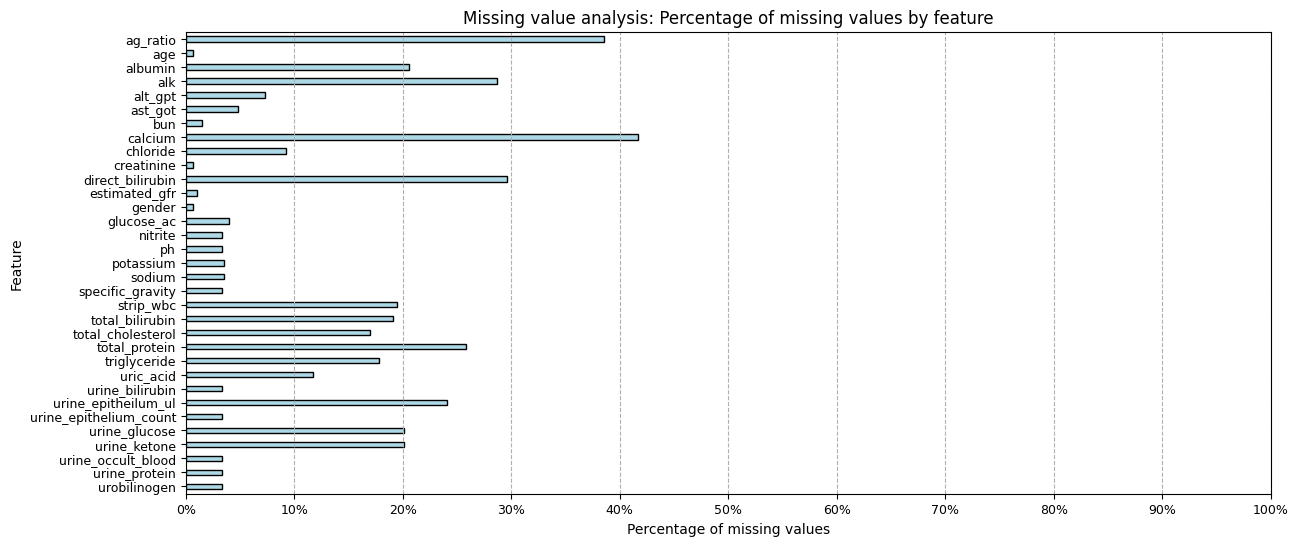

In [ ]:
# Plot horizontal bar chart showing percentage of missings per feature

plt.figure(figsize=(14, 6))
hbar_plot(comb2, 'Feature', 'All', 0.4, 'Percentage of missing values', 'Missing value analysis: Percentage of missing values by feature')
plt.show()


<font color='red'>Relatively low levels of missing except for a couple of features with over 40% missing</font>

##### 5.1.2. Percentage of missing values by feature and class of disease

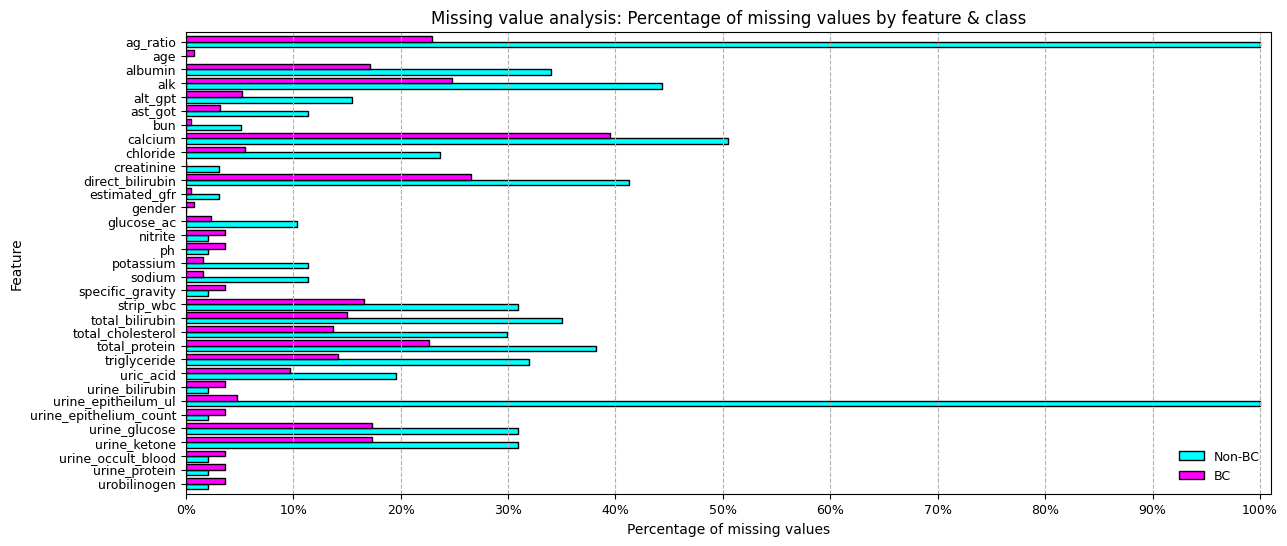

In [ ]:
# Plot horizontal bar chart showing percentage of missings per feature and class

plt.figure(figsize=(14, 6))
hbar_target_plot(comb2,'Feature',0.4,'Non-BC','BC','Percentage of missing values','Missing value analysis: Percentage of missing values by feature & class')
plt.show()

<font color='red'>'ag_ratio' and 'urine_epithelium_count' have no values for one class of target feature so will be removed from the analysis</font>

In [ ]:
# Drop 'ag_ratio'and 'urine_epitheilum_ul'
df=df.drop(columns=['ag_ratio','urine_epitheilum_ul'], axis=1)
# Apply to test data
df_test=df_test.drop(columns=['ag_ratio','urine_epitheilum_ul'], axis=1)

#### 5.2. Distribution analysis

##### 5.2.1. Distributions of sample values by feature

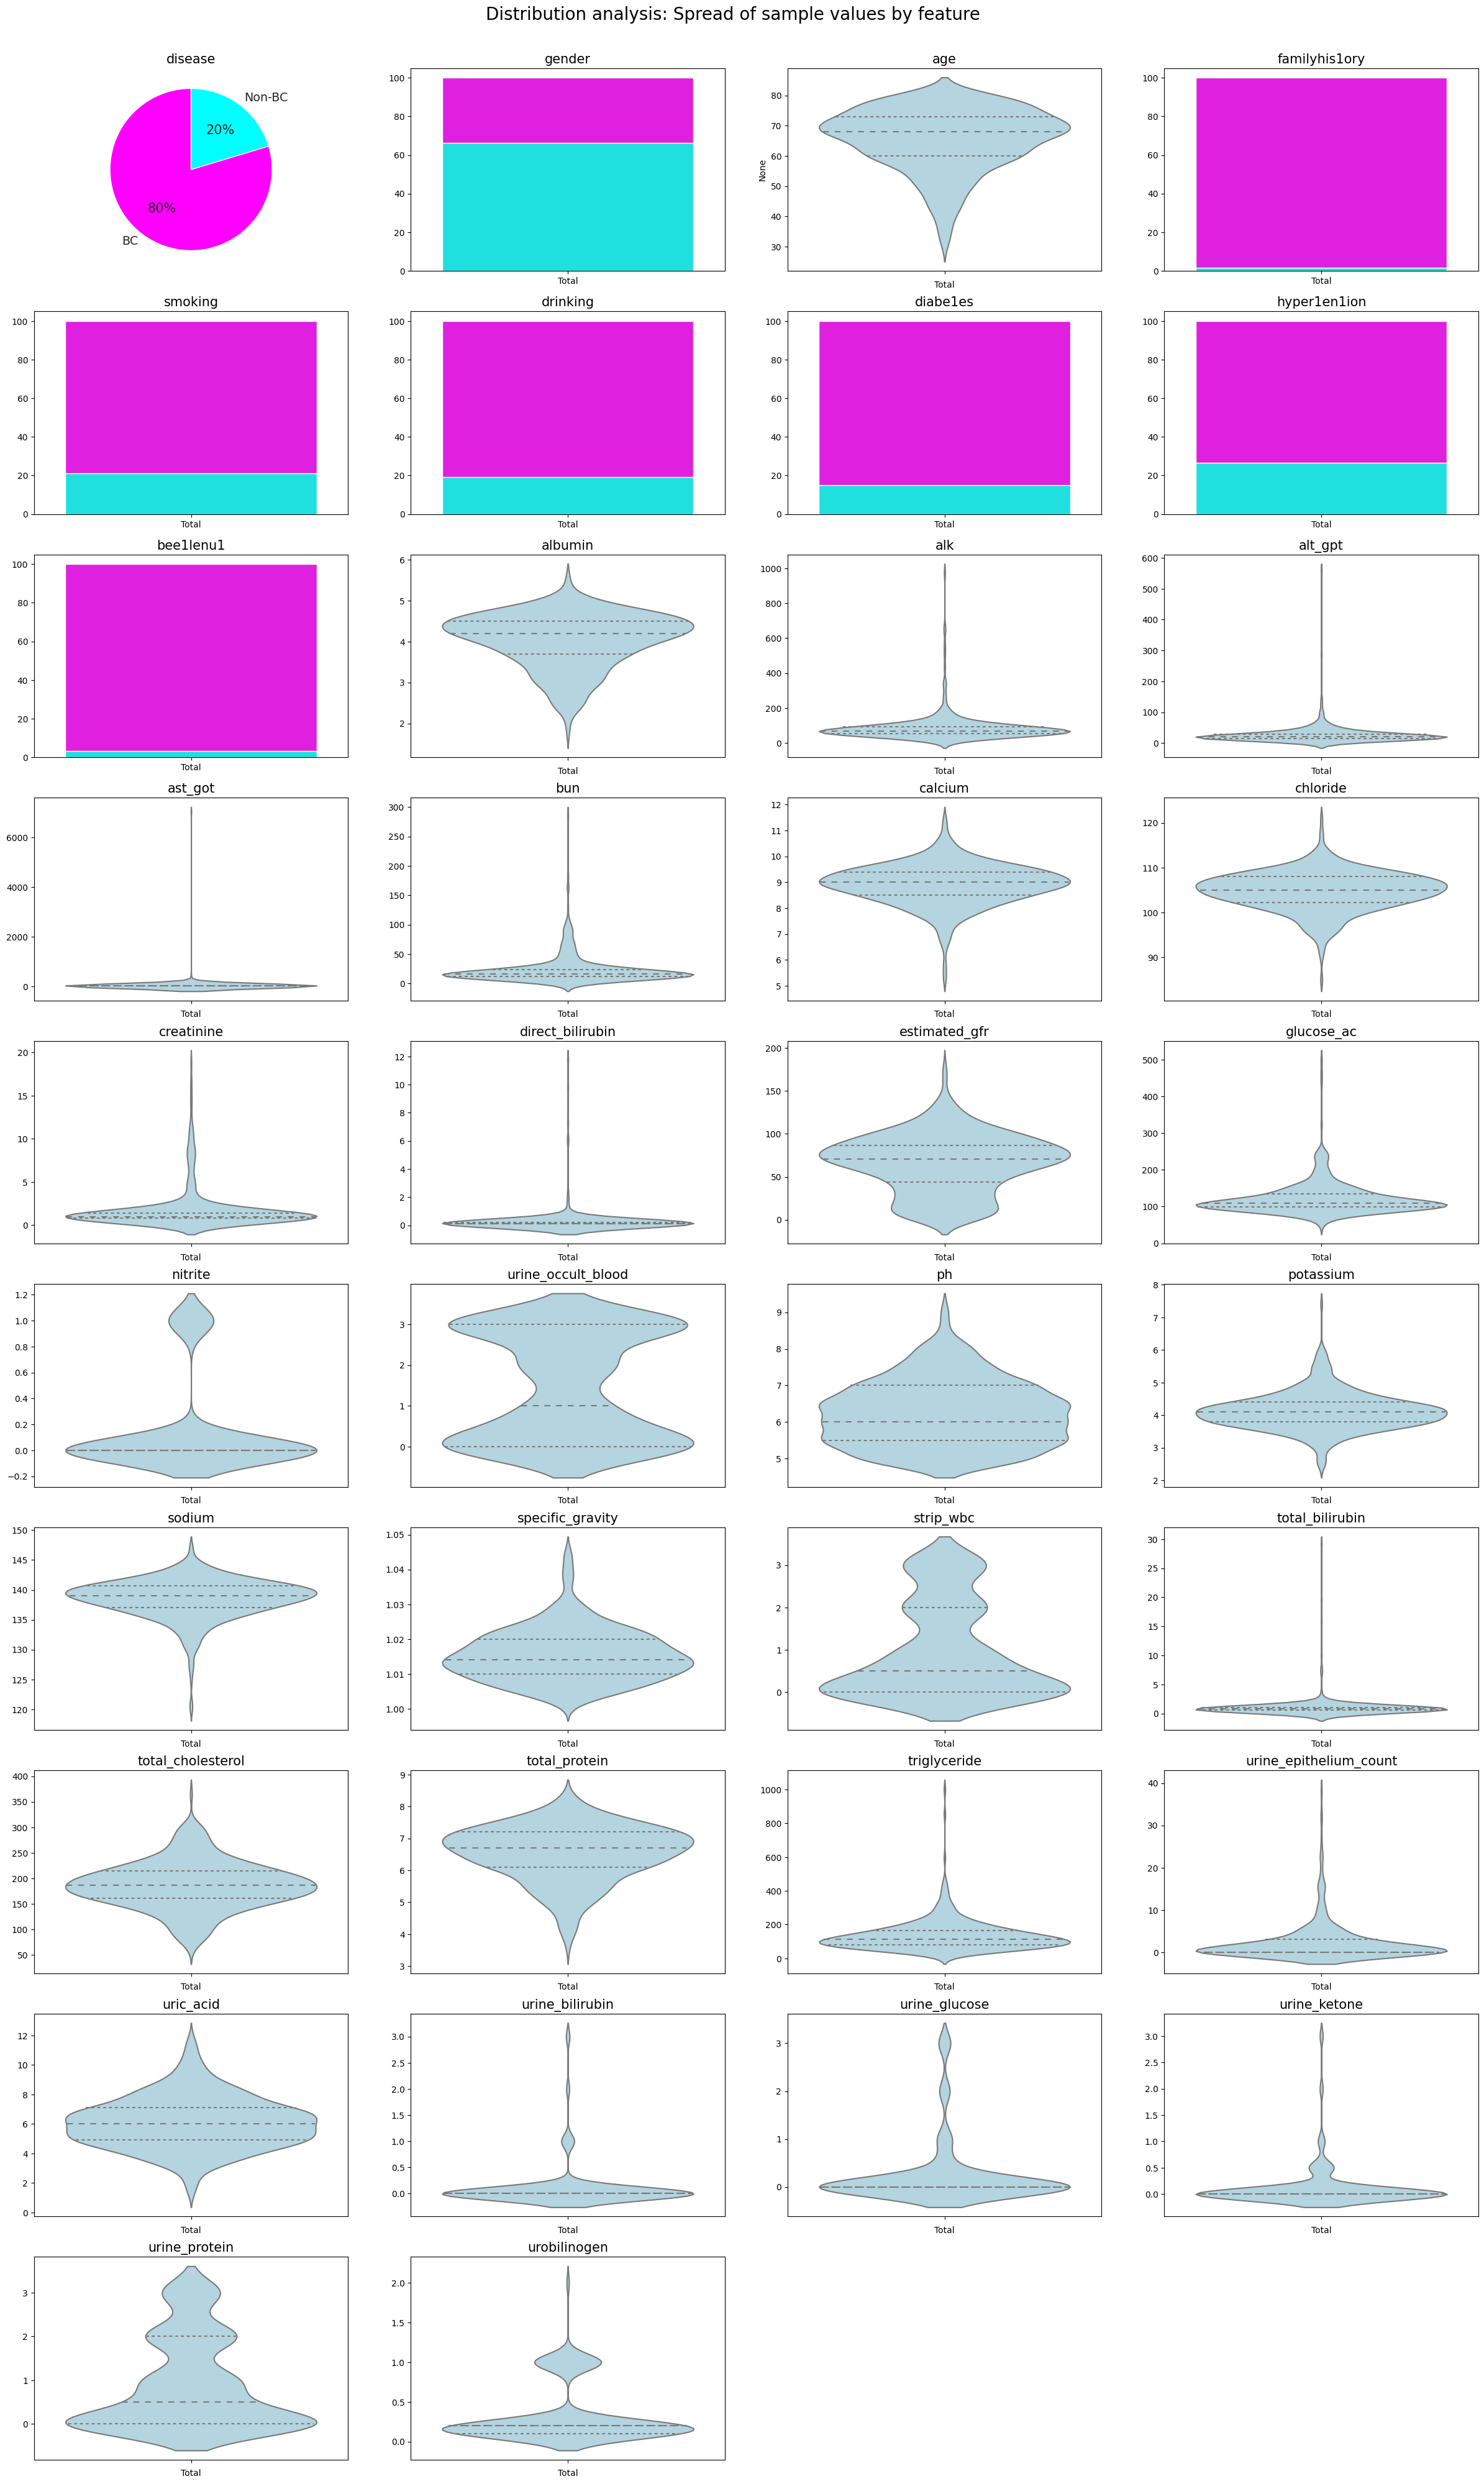

In [ ]:
fig, axes=plt.subplots(10,4,figsize=(30,50))

fig.suptitle('Distribution analysis: Spread of sample values by feature',fontsize=20, y=0.9)
sns.set(font_scale=1.25)

# Remove empty panes
fig.delaxes(axes[9][2])
fig.delaxes(axes[9][3])

piechart(df,'disease',0,0)
stackpercplot2(df,'disease','gender','yes','no',0,1)
sns.violinplot(x=None,y='age', data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[0,2]).set(title='age',xlabel='Total',ylabel='None')
stackpercplot2(df,'disease','familyhis1ory','yes','no',0,3)

stackpercplot2(df,'disease','smoking','yes','no',1,0)
stackpercplot2(df,'disease','drinking','yes','no',1,1)
stackpercplot2(df,'disease','diabe1es','yes','no',1,2)
stackpercplot2(df,'disease','hyper1en1ion','yes','no',1,3)

stackpercplot2(df,'disease','bee1lenu1','yes','no',2,0)
sns.violinplot(x=None,y='albumin',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[2,1]).set(title='albumin',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='alk',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[2,2]).set(title='alk',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='alt_gpt',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[2,3]).set(title='alt_gpt',xlabel='Total',ylabel=None)

sns.violinplot(x=None,y='ast_got',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[3,0]).set(title='ast_got',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='bun',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[3,1]).set(title='bun',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='calcium',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[3,2]).set(title='calcium',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='chloride',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[3,3]).set(title='chloride',xlabel='Total',ylabel=None)

sns.violinplot(x=None,y='creatinine',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[4,0]).set(title='creatinine',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='direct_bilirubin',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[4,1]).set(title='direct_bilirubin',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='estimated_gfr',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[4,2]).set(title='estimated_gfr',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='glucose_ac',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[4,3]).set(title='glucose_ac',xlabel='Total',ylabel=None)

sns.violinplot(x=None,y='nitrite',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[5,0]).set(title='nitrite',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='urine_occult_blood',data=df,inner="quartile",palette=sns.color_palette(['lightblue']), ax=axes[5,1]).set(title='urine_occult_blood',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='ph',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[5,2]).set(title='ph',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='potassium', data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[5,3]).set(title='potassium',xlabel='Total',ylabel=None)

sns.violinplot(x=None,y='sodium',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[6,0]).set(title='sodium',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='specific_gravity',data=df,inner="quartile",palette=sns.color_palette(['lightblue']), ax=axes[6,1]).set(title='specific_gravity',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='strip_wbc',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[6,2]).set(title='strip_wbc',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='total_bilirubin', data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[6,3]).set(title='total_bilirubin',xlabel='Total',ylabel=None)

sns.violinplot(x=None,y='total_cholesterol',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[7,0]).set(title='total_cholesterol',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='total_protein',data=df,inner="quartile",palette=sns.color_palette(['lightblue']), ax=axes[7,1]).set(title='total_protein',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='triglyceride',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[7,2]).set(title='triglyceride',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='urine_epithelium_count',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[7,3]).set(title='urine_epithelium_count',xlabel='Total',ylabel=None)

sns.violinplot(x=None,y='uric_acid',data=df,inner="quartile",palette=sns.color_palette(['lightblue']), ax=axes[8,0]).set(title='uric_acid',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='urine_bilirubin',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[8,1]).set(title='urine_bilirubin',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='urine_glucose', data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[8,2]).set(title='urine_glucose',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='urine_ketone',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[8,3]).set(title='urine_ketone',xlabel='Total',ylabel=None)

sns.violinplot(x=None,y='urine_protein',data=df,inner="quartile",palette=sns.color_palette(['lightblue']), ax=axes[9,0]).set(title='urine_protein',xlabel='Total',ylabel=None)
sns.violinplot(x=None,y='urobilinogen',data=df,inner="quartile",palette=sns.color_palette(['lightblue']),ax=axes[9,1]).set(title='urobilinogen',xlabel='Total',ylabel=None)

plt.show()

##### 5.2.2. Distributions of sample values by feature and class of disease

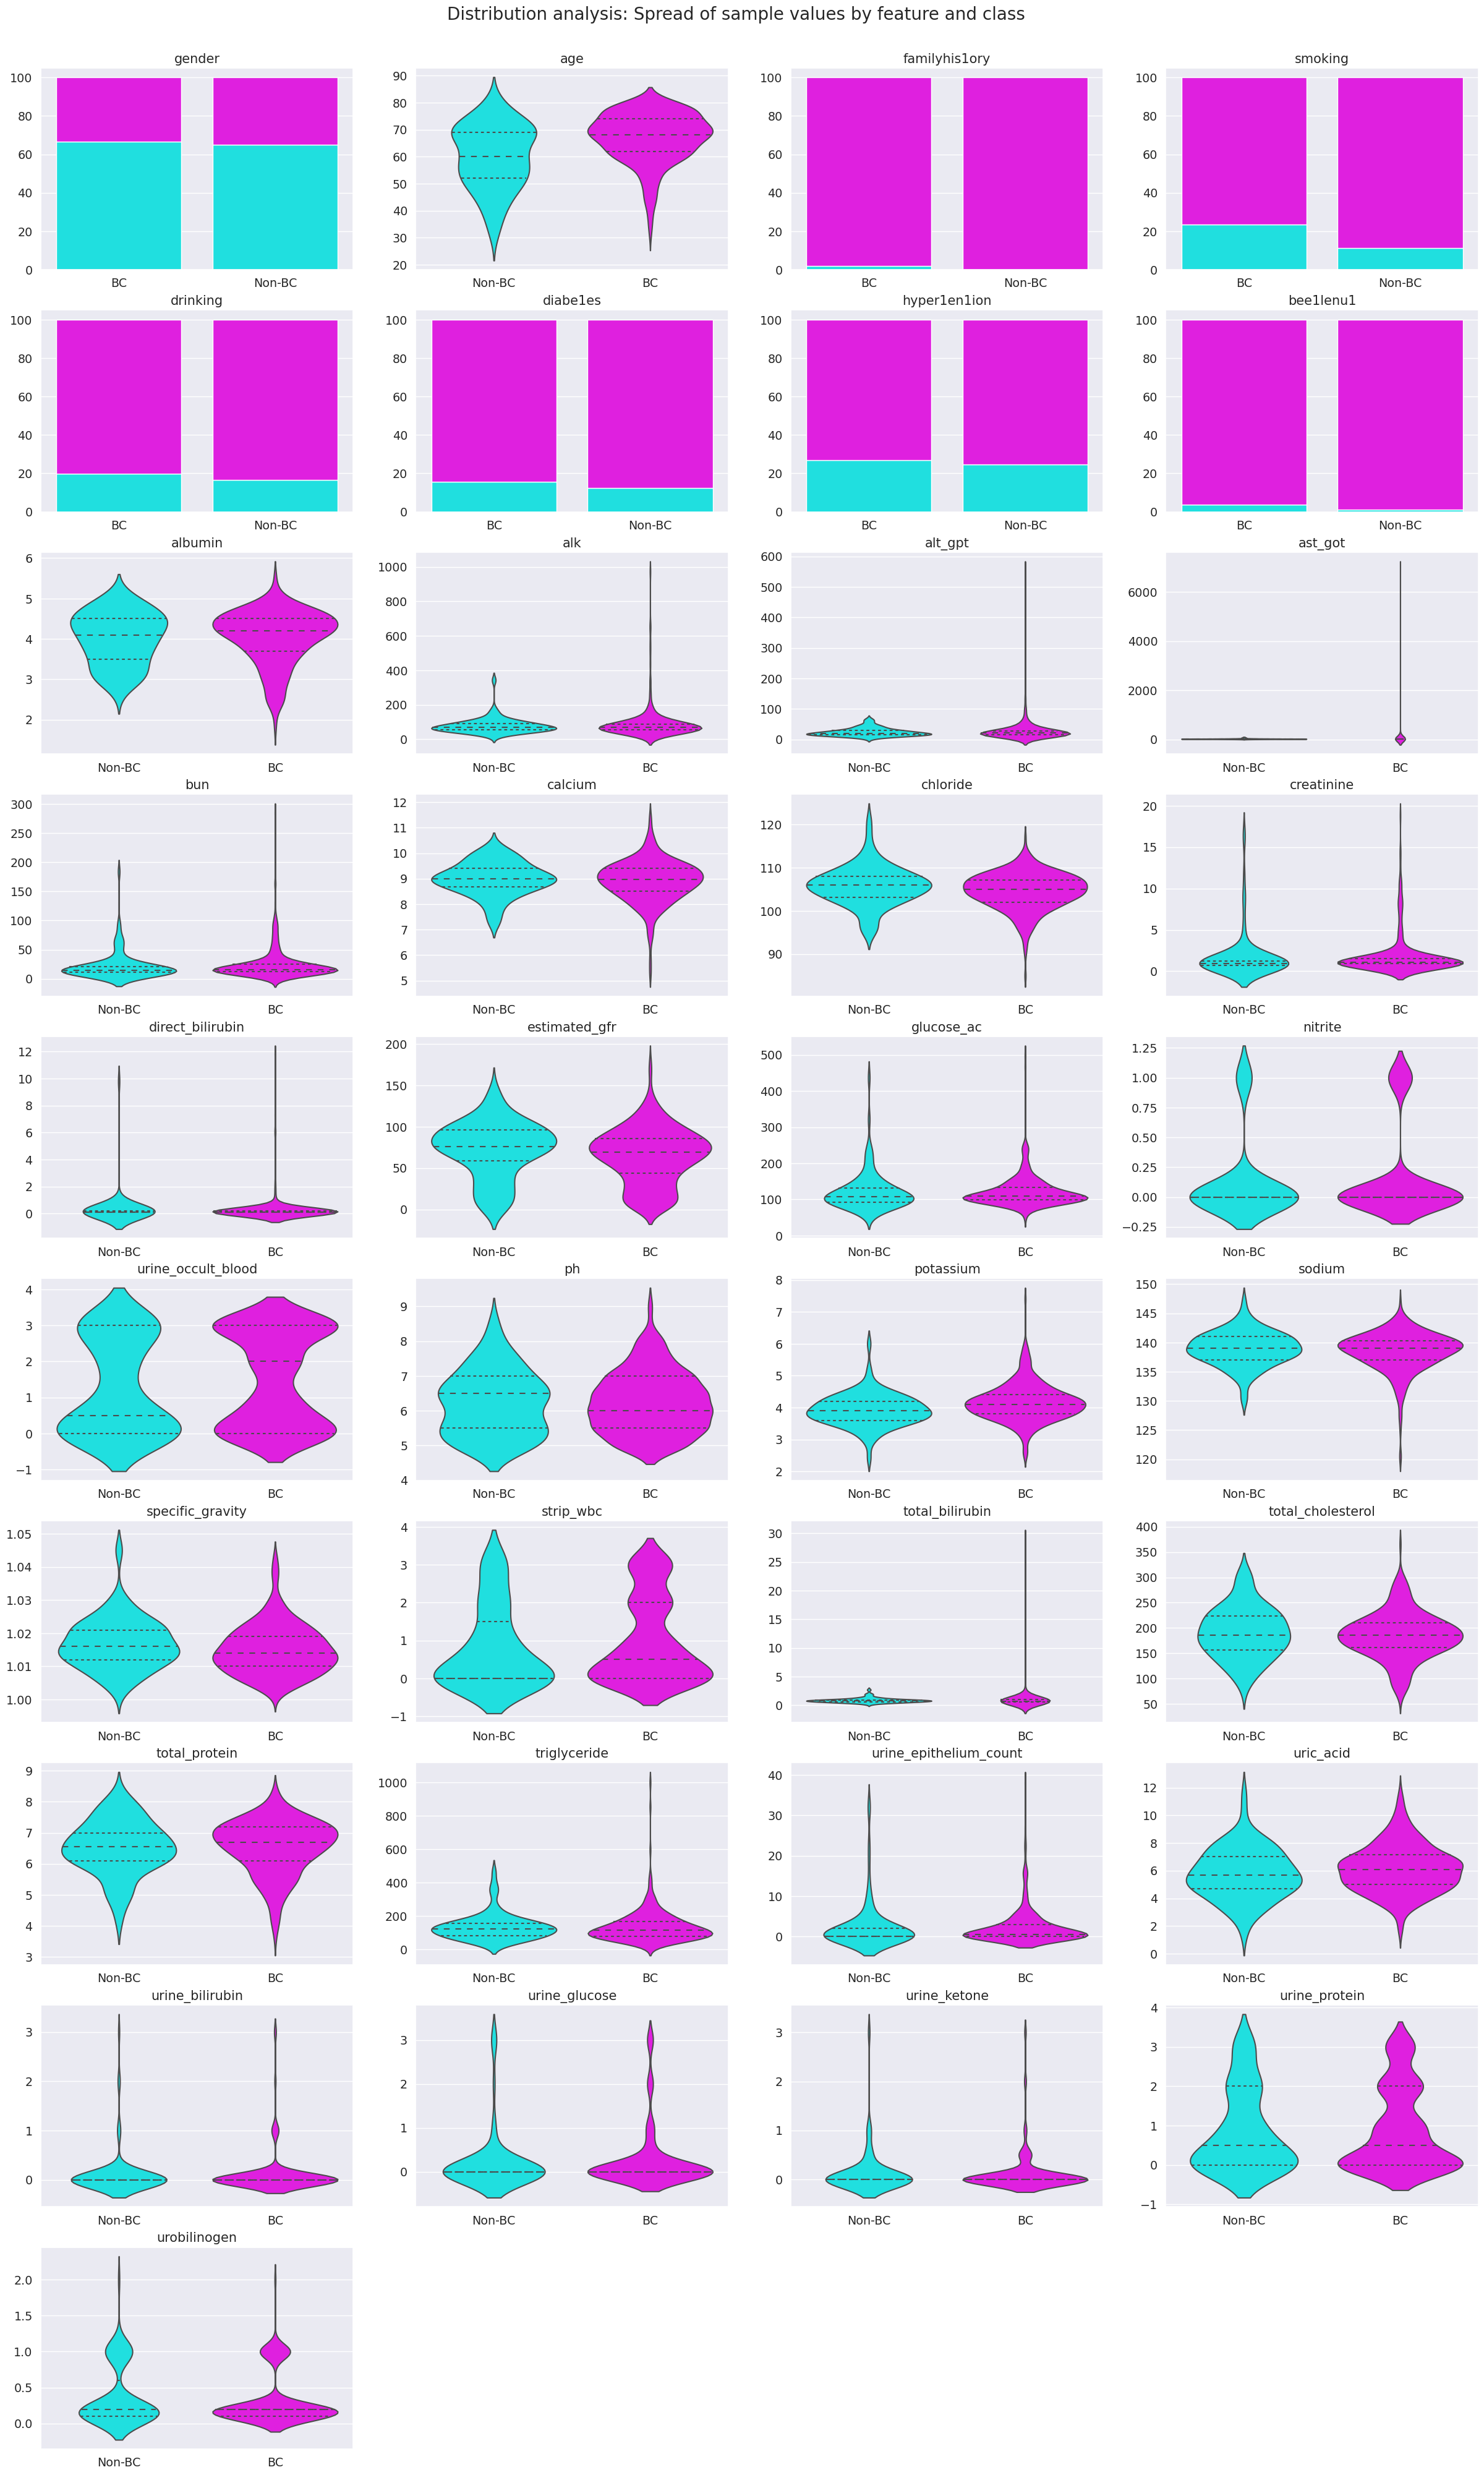

In [ ]:
fig, axes=plt.subplots(10,4,figsize=(30,50))

fig.suptitle('Distribution analysis: Spread of sample values by feature and class',fontsize=20, y=0.9)
sns.set(font_scale=1.25)

# Remove empty panes
fig.delaxes(axes[9][1])
fig.delaxes(axes[9][2])
fig.delaxes(axes[9][3])

stackpercplot(df,'disease','gender','yes','no',0,0)
sns.violinplot(x='disease',y='age', data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[0,1]).set(title='age',xlabel=None,ylabel=None)
stackpercplot(df,'disease','familyhis1ory','yes','no',0,2)
stackpercplot(df,'disease','smoking','yes','no',0,3)

stackpercplot(df,'disease','drinking','yes','no',1,0)
stackpercplot(df,'disease','diabe1es','yes','no',1,1)
stackpercplot(df,'disease','hyper1en1ion','yes','no',1,2)
stackpercplot(df,'disease','bee1lenu1','yes','no',1,3)

sns.violinplot(x='disease',y='albumin',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[2,0]).set(title='albumin',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='alk',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[2,1]).set(title='alk',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='alt_gpt',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[2,2]).set(title='alt_gpt',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='ast_got',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[2,3]).set(title='ast_got',xlabel=None,ylabel=None)

sns.violinplot(x='disease',y='bun',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[3,0]).set(title='bun',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='calcium',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[3,1]).set(title='calcium',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='chloride',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[3,2]).set(title='chloride',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='creatinine',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[3,3]).set(title='creatinine',xlabel=None,ylabel=None)

sns.violinplot(x='disease',y='direct_bilirubin',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[4,0]).set(title='direct_bilirubin',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='estimated_gfr',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[4,1]).set(title='estimated_gfr',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='glucose_ac',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[4,2]).set(title='glucose_ac',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='nitrite',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[4,3]).set(title='nitrite',xlabel=None,ylabel=None)

sns.violinplot(x='disease',y='urine_occult_blood',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']), ax=axes[5,0]).set(title='urine_occult_blood',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='ph',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[5,1]).set(title='ph',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='potassium', data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[5,2]).set(title='potassium',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='sodium',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[5,3]).set(title='sodium',xlabel=None,ylabel=None)

sns.violinplot(x='disease',y='specific_gravity',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']), ax=axes[6,0]).set(title='specific_gravity',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='strip_wbc',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[6,1]).set(title='strip_wbc',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='total_bilirubin', data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[6,2]).set(title='total_bilirubin',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='total_cholesterol',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[6,3]).set(title='total_cholesterol',xlabel=None,ylabel=None)

sns.violinplot(x='disease',y='total_protein',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']), ax=axes[7,0]).set(title='total_protein',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='triglyceride',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[7,1]).set(title='triglyceride',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='urine_epithelium_count',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[7,2]).set(title='urine_epithelium_count',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='uric_acid',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']), ax=axes[7,3]).set(title='uric_acid',xlabel=None,ylabel=None)

sns.violinplot(x='disease',y='urine_bilirubin',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[8,0]).set(title='urine_bilirubin',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='urine_glucose', data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[8,1]).set(title='urine_glucose',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='urine_ketone',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[8,2]).set(title='urine_ketone',xlabel=None,ylabel=None)
sns.violinplot(x='disease',y='urine_protein',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']), ax=axes[8,3]).set(title='urine_protein',xlabel=None,ylabel=None)

sns.violinplot(x='disease',y='urobilinogen',data=df,inner="quartile",palette=sns.color_palette(['cyan','magenta']),ax=axes[9,0]).set(title='urobilinogen',xlabel=None,ylabel=None)

plt.show()

<font color='red'>While fully populated there are no instances of 'familyhis1ory' for one class of the target feature so it provides no discriminatory power, i.e it doesn't contribute any information to distinguish between the classes so it will be removed from the analysis</font>

In [ ]:
# Drop 'familyhis1ory'
df=df.drop(columns=['familyhis1ory'], axis=1)
# Apply to test data
df_test=df_test.drop(columns=['familyhis1ory'], axis=1)

##### 5.2.3. Distribution statistics by feature

In [ ]:
# All samples
df_all=df.drop(columns=['disease','disease1']).describe(include='all',percentiles=[.01,.05,.25,.5,.75,0.95,0.99])
df_all.loc['size'] = len(df)
df_all.loc['% miss'] = df.isnull().mean()

In [ ]:
df_all.iloc[:,[29,30,31,32,33,34,35,0,1,2,3,4,5,6]]

age      gender  hyper1en1ion    diabe1es     smoking  \
count   474.000000  474.000000    477.000000  477.000000  477.000000   
mean     65.457806    0.662447      0.264151    0.148847    0.209644   
std      10.262481    0.473375      0.441343    0.356311    0.407482   
min      31.000000    0.000000      0.000000    0.000000    0.000000   
1%       35.000000    0.000000      0.000000    0.000000    0.000000   
5%       44.000000    0.000000      0.000000    0.000000    0.000000   
25%      60.000000    0.000000      0.000000    0.000000    0.000000   
50%      68.000000    1.000000      0.000000    0.000000    0.000000   
75%      73.000000    1.000000      1.000000    0.000000    0.000000   
95%      79.000000    1.000000      1.000000    1.000000    1.000000   
99%      80.000000    1.000000      1.000000    1.000000    1.000000   
max      80.000000    1.000000      1.000000    1.000000    1.000000   
size    477.000000  477.000000    477.000000  477.000000  477.000000   
% miss    0.006289    0.006289      0.000000    0.000000    0.000000   

          drinking   bee1lenu1     albumin         alk     alt_gpt  \
count   477.000000  477.000000  379.000000  340.000000  442.000000   
mean      0.190776    0.031447    4.034644   88.520588   27.454751   
std       0.393325    0.174704    0.658680   87.175286   33.516490   
min       0.000000    0.000000    1.800000   25.000000    4.000000   
1%        0.000000    0.000000    2.378000   34.560000    7.000000   
5%        0.000000    0.000000    2.700000   41.000000   11.000000   
25%       0.000000    0.000000    3.700000   55.000000   15.000000   
50%       0.000000    0.000000    4.200000   69.000000   21.000000   
75%       0.000000    0.000000    4.500000   91.000000   28.750000   
95%       1.000000    0.000000    4.863000  177.050000   60.950000   
99%       1.000000    1.000000    5.100000  539.330000  120.620000   
max       1.000000    1.000000    5.500000  972.000000  561.000000   
size    477.000000  477.000000  477.000000  477.000000  477.000000   
% miss    0.000000    0.000000    0.205451    0.287212    0.073375   

            ast_got         bun     calcium    chloride  
count    454.000000  470.000000  278.000000  433.000000  
mean      43.462555   24.138723    8.912374  104.813164  
std      329.370162   25.880354    0.787064    4.285828  
min        5.000000    2.000000    5.300000   85.000000  
1%        10.530000    4.690000    6.733300   93.320000  
5%        14.000000    8.000000    7.698500   97.000000  
25%       19.000000   12.000000    8.500000  102.200000  
50%       23.000000   16.000000    9.000000  105.000000  
75%       28.000000   24.000000    9.400000  108.000000  
95%       56.000000   74.100000   10.000000  111.000000  
99%      122.470000  115.510000   10.623000  114.000000  
max     7024.000000  285.000000   11.400000  121.000000  
size     477.000000  477.000000  477.000000  477.000000  
% miss     0.048218    0.014675    0.417191    0.092243

In [ ]:
df_all.iloc[:,8:22]

direct_bilirubin  estimated_gfr  glucose_ac     nitrite  \
count         336.000000     472.000000  458.000000  461.000000   
mean            0.291399      66.084958  122.229258    0.151844   
std             1.034595      33.598399   45.827737    0.359259   
min             0.000000       2.600000   51.000000    0.000000   
1%              0.000000       3.642000   68.570000    0.000000   
5%              0.000000       5.255000   84.000000    0.000000   
25%             0.100000      44.075000   98.250000    0.000000   
50%             0.100000      70.800000  109.000000    0.000000   
75%             0.200000      86.425000  133.750000    0.000000   
95%             0.517500     114.895000  203.750000    1.000000   
99%             6.095000     138.063000  250.000000    1.000000   
max            11.800000     177.700000  499.000000    1.000000   
size          477.000000     477.000000  477.000000  477.000000   
% miss          0.295597       0.010482    0.039832    0.033543   

        urine_occult_blood          ph   potassium      sodium  \
count           461.000000  461.000000  460.000000  460.000000   
mean              1.467462    6.244035    4.119370  138.553043   
std               1.297164    0.880089    0.573100    3.279714   
min               0.000000    5.000000    2.420000  120.000000   
1%                0.000000    5.000000    2.659000  127.590000   
5%                0.000000    5.000000    3.400000  133.000000   
25%               0.000000    5.500000    3.800000  137.000000   
50%               1.000000    6.000000    4.100000  139.000000   
75%               3.000000    7.000000    4.400000  140.700000   
95%               3.000000    8.000000    5.100000  143.000000   
99%               3.000000    8.500000    5.823300  144.410000   
max               3.000000    9.000000    7.400000  147.000000   
size            477.000000  477.000000  477.000000  477.000000   
% miss            0.033543    0.033543    0.035639    0.035639   

        specific_gravity   strip_wbc  total_bilirubin  total_cholesterol  \
count         461.000000  384.000000       386.000000         396.000000   
mean            1.015490    0.977865         1.062358         186.065657   
std             0.007573    1.104302         2.058729          46.648654   
min             1.001000    0.000000         0.000000          60.000000   
1%              1.003000    0.000000         0.200000          80.950000   
5%              1.005000    0.000000         0.400000         106.000000   
25%             1.010000    0.000000         0.600000         160.750000   
50%             1.014000    0.500000         0.800000         186.000000   
75%             1.020000    2.000000         1.000000         214.250000   
95%             1.028000    3.000000         1.675000         270.250000   
99%             1.040400    3.000000         8.130000         299.050000   
max             1.045000    3.000000        29.200000         365.000000   
size          477.000000  477.000000       477.000000         477.000000   
% miss          0.033543    0.194969         0.190776           0.169811   

        total_protein  triglyceride  
count      354.000000    392.000000  
mean         6.533277    136.801020  
std          0.864727     96.109466  
min          3.600000     25.000000  
1%           4.137100     39.460000  
5%           5.000000     49.000000  
25%          6.100000     79.000000  
50%          6.700000    114.500000  
75%          7.200000    166.250000  
95%          7.700000    298.600000  
99%          8.147000    443.980000  
max          8.300000   1000.000000  
size       477.000000    477.000000  
% miss       0.257862      0.178197

In [ ]:
df_all.iloc[:,23:29]

uric_acid  urine_bilirubin  urine_glucose  urine_ketone  \
count   421.000000       461.000000     381.000000    381.000000   
mean      6.089240         0.108460       0.258530      0.119423   
std       1.749511         0.443742       0.696391      0.409802   
min       1.400000         0.000000       0.000000      0.000000   
1%        2.320000         0.000000       0.000000      0.000000   
5%        3.450000         0.000000       0.000000      0.000000   
25%       4.900000         0.000000       0.000000      0.000000   
50%       6.000000         0.000000       0.000000      0.000000   
75%       7.100000         0.000000       0.000000      0.000000   
95%       9.100000         1.000000       2.000000      0.500000   
99%      10.960000         3.000000       3.000000      2.200000   
max      11.800000         3.000000       3.000000      3.000000   
size    477.000000       477.000000     477.000000    477.000000   
% miss    0.117400         0.033543       0.201258      0.201258   

        urine_protein  urobilinogen  
count      461.000000    461.000000  
mean         0.891540      0.328850  
std          1.040565      0.361237  
min          0.000000      0.100000  
1%           0.000000      0.100000  
5%           0.000000      0.100000  
25%          0.000000      0.100000  
50%          0.500000      0.200000  
75%          2.000000      0.200000  
95%          3.000000      1.000000  
99%          3.000000      1.000000  
max          3.000000      2.000000  
size       477.000000    477.000000  
% miss       0.033543      0.033543

##### 5.2.4. Distribution statistics by feature & class

In [ ]:
# Get data

# Non-cancer samples
df0=df.loc[df['disease1']==0].drop(columns=['disease','disease1'])
df0a=df0.describe(include='all',percentiles=[.01,.05,.25,.5,.75,0.95,0.99])
df0a.loc['size'] = len(df0)
df0a.loc['% miss'] = df0.isnull().mean()

# Cancer samples
df1=df.loc[df['disease1']==1].drop(columns=['disease','disease1'])
df1a=df1.describe(include='all',percentiles=[.01,.05,.25,.5,.75,0.95,0.99])
df1a.loc['size'] = len(df1)
df1a.loc['% miss'] = df1.isnull().mean()

###### Non-cancer samples

In [ ]:
df0a.iloc[:,[29,30,31,32,33,34,35,0,1,2,3,4,5,6]]


age     gender  hyper1en1ion   diabe1es    smoking   drinking  \
count   97.000000  97.000000     97.000000  97.000000  97.000000  97.000000   
mean    59.886598   0.649485      0.247423   0.123711   0.113402   0.164948   
std     11.799432   0.479610      0.433756   0.330962   0.318731   0.373062   
min     31.000000   0.000000      0.000000   0.000000   0.000000   0.000000   
1%      31.960000   0.000000      0.000000   0.000000   0.000000   0.000000   
5%      39.600000   0.000000      0.000000   0.000000   0.000000   0.000000   
25%     52.000000   0.000000      0.000000   0.000000   0.000000   0.000000   
50%     60.000000   1.000000      0.000000   0.000000   0.000000   0.000000   
75%     69.000000   1.000000      0.000000   0.000000   0.000000   0.000000   
95%     76.000000   1.000000      1.000000   1.000000   1.000000   1.000000   
99%     80.000000   1.000000      1.000000   1.000000   1.000000   1.000000   
max     80.000000   1.000000      1.000000   1.000000   1.000000   1.000000   
size    97.000000  97.000000     97.000000  97.000000  97.000000  97.000000   
% miss   0.000000   0.000000      0.000000   0.000000   0.000000   0.000000   

        bee1lenu1    albumin         alk    alt_gpt    ast_got         bun  \
count   97.000000  64.000000   54.000000  82.000000  86.000000   92.000000   
mean     0.010309   4.010625   79.962963  24.573171  25.755814   22.273913   
std      0.101535   0.635435   46.826038  13.369424  13.656230   24.546014   
min      0.000000   2.700000   25.000000   4.000000   5.000000    7.000000   
1%       0.000000   2.826000   32.950000   5.620000  10.100000    7.910000   
5%       0.000000   3.000000   41.950000  11.000000  14.250000    8.000000   
25%      0.000000   3.500000   54.000000  16.000000  18.250000   11.000000   
50%      0.000000   4.100000   69.000000  20.000000  22.500000   14.000000   
75%      0.000000   4.500000   91.000000  28.750000  28.000000   21.000000   
95%      0.000000   4.886500  147.400000  50.750000  47.000000   65.575000   
99%      0.040000   5.018500  253.960000  64.570000  79.550000  103.010000   
max      1.000000   5.050000  343.000000  67.000000  94.000000  184.000000   
size    97.000000  97.000000   97.000000  97.000000  97.000000   97.000000   
% miss   0.000000   0.340206    0.443299   0.154639   0.113402    0.051546   

          calcium    chloride  
count   48.000000   74.000000  
mean     8.987292  105.818919  
std      0.650282    4.571762  
min      7.290000   95.000000  
1%       7.341700   95.657000  
5%       7.835000   97.000000  
25%      8.667500  103.150000  
50%      9.000000  106.000000  
75%      9.407500  108.000000  
95%     10.000000  112.700000  
99%     10.106000  118.810000  
max     10.200000  121.000000  
size    97.000000   97.000000  
% miss   0.505155    0.237113

In [ ]:
df0a.iloc[:,8:22]

direct_bilirubin  estimated_gfr  glucose_ac    nitrite  \
count          57.000000      94.000000   87.000000  95.000000   
mean            0.338421      72.279787  123.160920   0.126316   
std             1.281671      33.527837   54.833336   0.333967   
min             0.000000       3.200000   63.000000   0.000000   
1%              0.000000       3.665000   64.720000   0.000000   
5%              0.080000       6.725000   79.900000   0.000000   
25%             0.100000      58.400000   92.500000   0.000000   
50%             0.100000      76.050000  107.000000   0.000000   
75%             0.200000      96.525000  131.000000   0.000000   
95%             0.440000     119.980000  223.100000   1.000000   
99%             4.704000     134.828000  338.100000   1.000000   
max             9.800000     144.500000  437.000000   1.000000   
size           97.000000      97.000000   97.000000  97.000000   
% miss          0.412371       0.030928    0.103093   0.020619   

        urine_occult_blood         ph  potassium      sodium  \
count            95.000000  95.000000  86.000000   86.000000   
mean              1.278947   6.221053   3.929419  138.938372   
std               1.302036   0.918821   0.500062    2.910394   
min               0.000000   5.000000   2.420000  130.000000   
1%                0.000000   5.000000   2.828000  130.850000   
5%                0.000000   5.000000   3.192500  134.250000   
25%               0.000000   5.500000   3.600000  137.050000   
50%               0.500000   6.500000   3.900000  139.000000   
75%               3.000000   7.000000   4.200000  141.000000   
95%               3.000000   7.650000   4.600000  143.000000   
99%               3.000000   8.500000   5.320000  145.300000   
max               3.000000   8.500000   6.000000  147.000000   
size             97.000000  97.000000  97.000000   97.000000   
% miss            0.020619   0.020619   0.113402    0.113402   

        specific_gravity  strip_wbc  total_bilirubin  total_cholesterol  \
count          95.000000  67.000000        63.000000          68.000000   
mean            1.016884   0.813433         0.865714         191.058824   
std             0.007652   1.065420         0.411295          50.032790   
min             1.002000   0.000000         0.200000          83.000000   
1%              1.003880   0.000000         0.311600          96.400000   
5%              1.005700   0.000000         0.400000         111.000000   
25%             1.012000   0.000000         0.600000         156.000000   
50%             1.016000   0.000000         0.800000         186.000000   
75%             1.021000   1.500000         0.910000         224.000000   
95%             1.028300   3.000000         1.670000         286.600000   
99%             1.045000   3.000000         2.266000         300.980000   
max             1.045000   3.000000         2.700000         305.000000   
size           97.000000  97.000000        97.000000          97.000000   
% miss          0.020619   0.309278         0.350515           0.298969   

        total_protein  triglyceride  
count       60.000000     66.000000  
mean         6.518833    135.787879  
std          0.861957     80.465284  
min          4.170000     42.000000  
1%           4.423700     45.250000  
5%           5.000000     50.500000  
25%          6.100000     82.500000  
50%          6.550000    122.000000  
75%          7.000000    157.000000  
95%          7.805000    318.250000  
99%          8.082000    417.850000  
max          8.200000    464.000000  
size        97.000000     97.000000  
% miss       0.381443      0.319588

In [ ]:
df0a.iloc[:,23:29]

uric_acid  urine_bilirubin  urine_glucose  urine_ketone  \
count   78.000000        95.000000      67.000000     67.000000   
mean     5.775897         0.105263       0.208955      0.126866   
std      1.829348         0.448963       0.680626      0.429440   
min      1.400000         0.000000       0.000000      0.000000   
1%       2.093000         0.000000       0.000000      0.000000   
5%       3.185000         0.000000       0.000000      0.000000   
25%      4.705000         0.000000       0.000000      0.000000   
50%      5.700000         0.000000       0.000000      0.000000   
75%      7.035000         0.000000       0.000000      0.000000   
95%      8.315000         1.000000       1.700000      0.850000   
99%     10.599000         2.060000       3.000000      1.680000   
max     11.600000         3.000000       3.000000      3.000000   
size    97.000000        97.000000      97.000000     97.000000   
% miss   0.195876         0.020619       0.309278      0.309278   

        urine_protein  urobilinogen  
count       95.000000     95.000000  
mean         0.857895      0.375789  
std          1.033130      0.404421  
min          0.000000      0.100000  
1%           0.000000      0.100000  
5%           0.000000      0.100000  
25%          0.000000      0.100000  
50%          0.500000      0.200000  
75%          2.000000      0.600000  
95%          3.000000      1.000000  
99%          3.000000      1.060000  
max          3.000000      2.000000  
size        97.000000     97.000000  
% miss       0.020619      0.020619

###### Cancer samples

In [ ]:
df1a.iloc[:,[29,30,31,32,33,34,35,0,1,2,3,4,5,6]]

age      gender  hyper1en1ion    diabe1es     smoking  \
count   377.000000  377.000000    380.000000  380.000000  380.000000   
mean     66.891247    0.665782      0.268421    0.155263    0.234211   
std       9.320610    0.472343      0.443722    0.362633    0.424063   
min      31.000000    0.000000      0.000000    0.000000    0.000000   
1%       38.520000    0.000000      0.000000    0.000000    0.000000   
5%       47.800000    0.000000      0.000000    0.000000    0.000000   
25%      62.000000    0.000000      0.000000    0.000000    0.000000   
50%      68.000000    1.000000      0.000000    0.000000    0.000000   
75%      74.000000    1.000000      1.000000    0.000000    0.000000   
95%      79.000000    1.000000      1.000000    1.000000    1.000000   
99%      80.000000    1.000000      1.000000    1.000000    1.000000   
max      80.000000    1.000000      1.000000    1.000000    1.000000   
size    380.000000  380.000000    380.000000  380.000000  380.000000   
% miss    0.007895    0.007895      0.000000    0.000000    0.000000   

          drinking   bee1lenu1     albumin         alk     alt_gpt  \
count   380.000000  380.000000  315.000000  286.000000  360.000000   
mean      0.197368    0.036842    4.039524   90.136364   28.111111   
std       0.398537    0.188622    0.664181   92.818020   36.568917   
min       0.000000    0.000000    1.800000   28.000000    5.000000   
1%        0.000000    0.000000    2.314000   36.400000    7.000000   
5%        0.000000    0.000000    2.670000   41.000000   10.950000   
25%       0.000000    0.000000    3.700000   55.000000   15.000000   
50%       0.000000    0.000000    4.200000   68.500000   21.000000   
75%       0.000000    0.000000    4.500000   87.000000   28.250000   
95%       1.000000    0.000000    4.832000  180.250000   62.000000   
99%       1.000000    1.000000    5.100000  571.700000  129.640000   
max       1.000000    1.000000    5.500000  972.000000  561.000000   
size    380.000000  380.000000  380.000000  380.000000  380.000000   
% miss    0.000000    0.000000    0.171053    0.247368    0.052632   

            ast_got         bun     calcium    chloride  
count    368.000000  378.000000  230.000000  359.000000  
mean      47.600543   24.592593    8.896739  104.605850  
std      365.749033   26.206023    0.813083    4.201309  
min        9.000000    2.000000    5.300000   85.000000  
1%        10.670000    4.000000    6.594100   92.580000  
5%        14.000000    8.000000    7.694500   97.000000  
25%       19.000000   12.000000    8.500000  102.000000  
50%       23.000000   16.000000    8.970000  105.000000  
75%       29.000000   24.925000    9.400000  107.200000  
95%       56.000000   77.000000   10.027500  110.040000  
99%      143.130000  113.830000   10.671000  113.000000  
max     7024.000000  285.000000   11.400000  117.000000  
size     380.000000  380.000000  380.000000  380.000000  
% miss     0.031579    0.005263    0.394737    0.055263

In [ ]:
df1a.iloc[:,8:22]

direct_bilirubin  estimated_gfr  glucose_ac     nitrite  \
count         279.000000     378.000000  371.000000  366.000000   
mean            0.281792      64.544444  122.010782    0.158470   
std             0.978984      33.482341   43.530479    0.365681   
min             0.000000       2.600000   51.000000    0.000000   
1%              0.000000       3.731000   69.700000    0.000000   
5%              0.000000       4.970000   85.000000    0.000000   
25%             0.100000      43.450000   99.000000    0.000000   
50%             0.100000      68.950000  110.000000    0.000000   
75%             0.200000      85.575000  134.000000    0.000000   
95%             0.507000     114.315000  197.000000    1.000000   
99%             5.966000     137.781000  247.900000    1.000000   
max            11.800000     177.700000  499.000000    1.000000   
size          380.000000     380.000000  380.000000  380.000000   
% miss          0.265789       0.005263    0.023684    0.036842   

        urine_occult_blood          ph   potassium      sodium  \
count           366.000000  366.000000  374.000000  374.000000   
mean              1.516393    6.250000    4.163048  138.464439   
std               1.293187    0.870954    0.580478    3.356222   
min               0.000000    5.000000    2.500000  120.000000   
1%                0.000000    5.000000    2.673000  127.000000   
5%                0.000000    5.000000    3.400000  133.000000   
25%               0.000000    5.500000    3.800000  137.000000   
50%               2.000000    6.000000    4.100000  139.000000   
75%               3.000000    7.000000    4.400000  140.300000   
95%               3.000000    8.000000    5.205000  143.000000   
99%               3.000000    8.175000    5.805100  144.000000   
max               3.000000    9.000000    7.400000  147.000000   
size            380.000000  380.000000  380.000000  380.000000   
% miss            0.036842    0.036842    0.015789    0.015789   

        specific_gravity   strip_wbc  total_bilirubin  total_cholesterol  \
count         366.000000  317.000000       323.000000         328.000000   
mean            1.015128    1.012618         1.100712         185.030488   
std             0.007521    1.110863         2.241873          45.928801   
min             1.001000    0.000000         0.000000          60.000000   
1%              1.003000    0.000000         0.200000          80.270000   
5%              1.005000    0.000000         0.373000         100.800000   
25%             1.010000    0.000000         0.600000         161.000000   
50%             1.014000    0.500000         0.700000         185.500000   
75%             1.019000    2.000000         1.000000         210.000000   
95%             1.028000    3.000000         1.600000         267.650000   
99%             1.039350    3.000000         9.516000         296.730000   
max             1.043000    3.000000        29.200000         365.000000   
size          380.000000  380.000000       380.000000         380.000000   
% miss          0.036842    0.165789         0.150000           0.136842   

        total_protein  triglyceride  
count      294.000000    326.000000  
mean         6.536224    137.006135  
std          0.866728     99.084175  
min          3.600000     25.000000  
1%           4.093000     35.500000  
5%           4.965000     49.000000  
25%          6.100000     79.000000  
50%          6.700000    113.000000  
75%          7.200000    167.750000  
95%          7.700000    293.500000  
99%          8.107000    439.000000  
max          8.300000   1000.000000  
size       380.000000    380.000000  
% miss       0.226316      0.142105

In [ ]:
df1a.iloc[:,23:29]

uric_acid  urine_bilirubin  urine_glucose  urine_ketone  \
count   343.000000       366.000000     314.000000    314.000000   
mean      6.160496         0.109290       0.269108      0.117834   
std       1.725666         0.442992       0.700320      0.406183   
min       1.500000         0.000000       0.000000      0.000000   
1%        2.442000         0.000000       0.000000      0.000000   
5%        3.600000         0.000000       0.000000      0.000000   
25%       5.000000         0.000000       0.000000      0.000000   
50%       6.100000         0.000000       0.000000      0.000000   
75%       7.145000         0.000000       0.000000      0.000000   
95%       9.190000         1.000000       2.000000      0.500000   
99%      10.916000         3.000000       3.000000      2.000000   
max      11.800000         3.000000       3.000000      3.000000   
size    380.000000       380.000000     380.000000    380.000000   
% miss    0.097368         0.036842       0.173684      0.173684   

        urine_protein  urobilinogen  
count      366.000000    366.000000  
mean         0.900273      0.316667  
std          1.043716      0.348729  
min          0.000000      0.100000  
1%           0.000000      0.100000  
5%           0.000000      0.100000  
25%          0.000000      0.100000  
50%          0.500000      0.200000  
75%          2.000000      0.200000  
95%          3.000000      1.000000  
99%          3.000000      1.000000  
max          3.000000      2.000000  
size       380.000000    380.000000  
% miss       0.036842      0.036842

#### 5.3. Variance analysis of features


In [ ]:
# Create an instance of VarianceThreshold with a threshold value
variance_threshold=VarianceThreshold(threshold=0)

# Fit and transform the df using VarianceThreshold to remove features with variance below the specified threshold
variance_threshold.fit_transform(df.drop(columns=['disease'],axis=1))

# Get the mask of features above threshold
selected_features_mask=variance_threshold.get_support()
# Print the features with variability above the threshold
print(df.drop(columns=['disease'],axis=1).columns[selected_features_mask])
print(len(df.drop(columns=['disease'],axis=1).columns[selected_features_mask]))

Index(['albumin', 'alk', 'alt_gpt', 'ast_got', 'bun', 'calcium', 'chloride',
       'creatinine', 'direct_bilirubin', 'estimated_gfr', 'glucose_ac',
       'nitrite', 'urine_occult_blood', 'ph', 'potassium', 'sodium',
       'specific_gravity', 'strip_wbc', 'total_bilirubin', 'total_cholesterol',
       'total_protein', 'triglyceride', 'urine_epithelium_count', 'uric_acid',
       'urine_bilirubin', 'urine_glucose', 'urine_ketone', 'urine_protein',
       'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'diabe1es', 'smoking',
       'drinking', 'bee1lenu1', 'disease1'],
      dtype='object')
37


<font color='red'>All remaining features have variance in their observed values so none need to be removed</font>

#### 5.4. Feature pairwise monotonicity analysis

##### 5.4.1 All samples

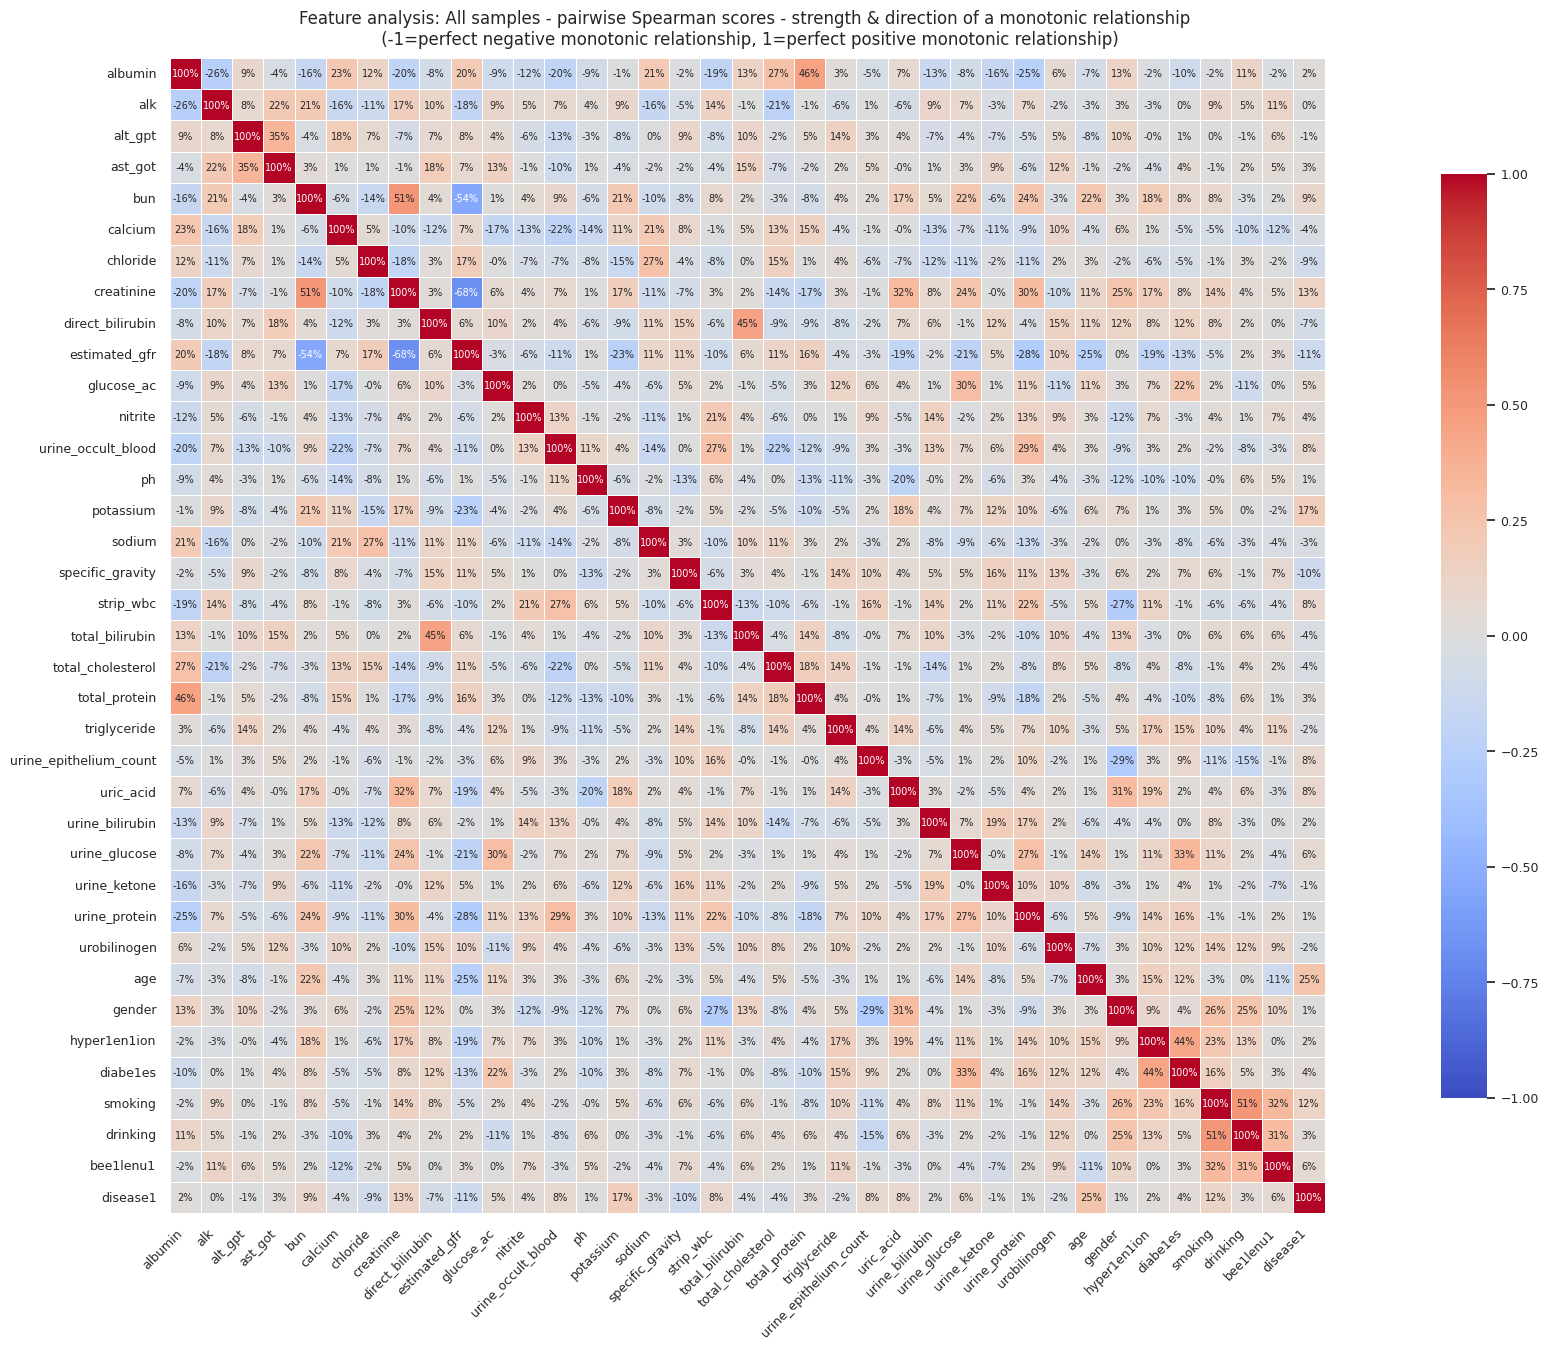

In [ ]:
# Get pairwise Spearman scores of strength of monotonic relationships for each pair of features
corr=df.corr('spearman')
# Did not consider 'ag_ratio' or 'urine_epitheilum_ul' as all missing for non-BC cases
heatmap_plot(corr,'All samples')

<font color='red'>Some features have high positive or negative monotonic relationships but will be retained for modelling stage in case of partial relationships (e.g. partial correlations)</font>

5.4.2 Non-cancer samples

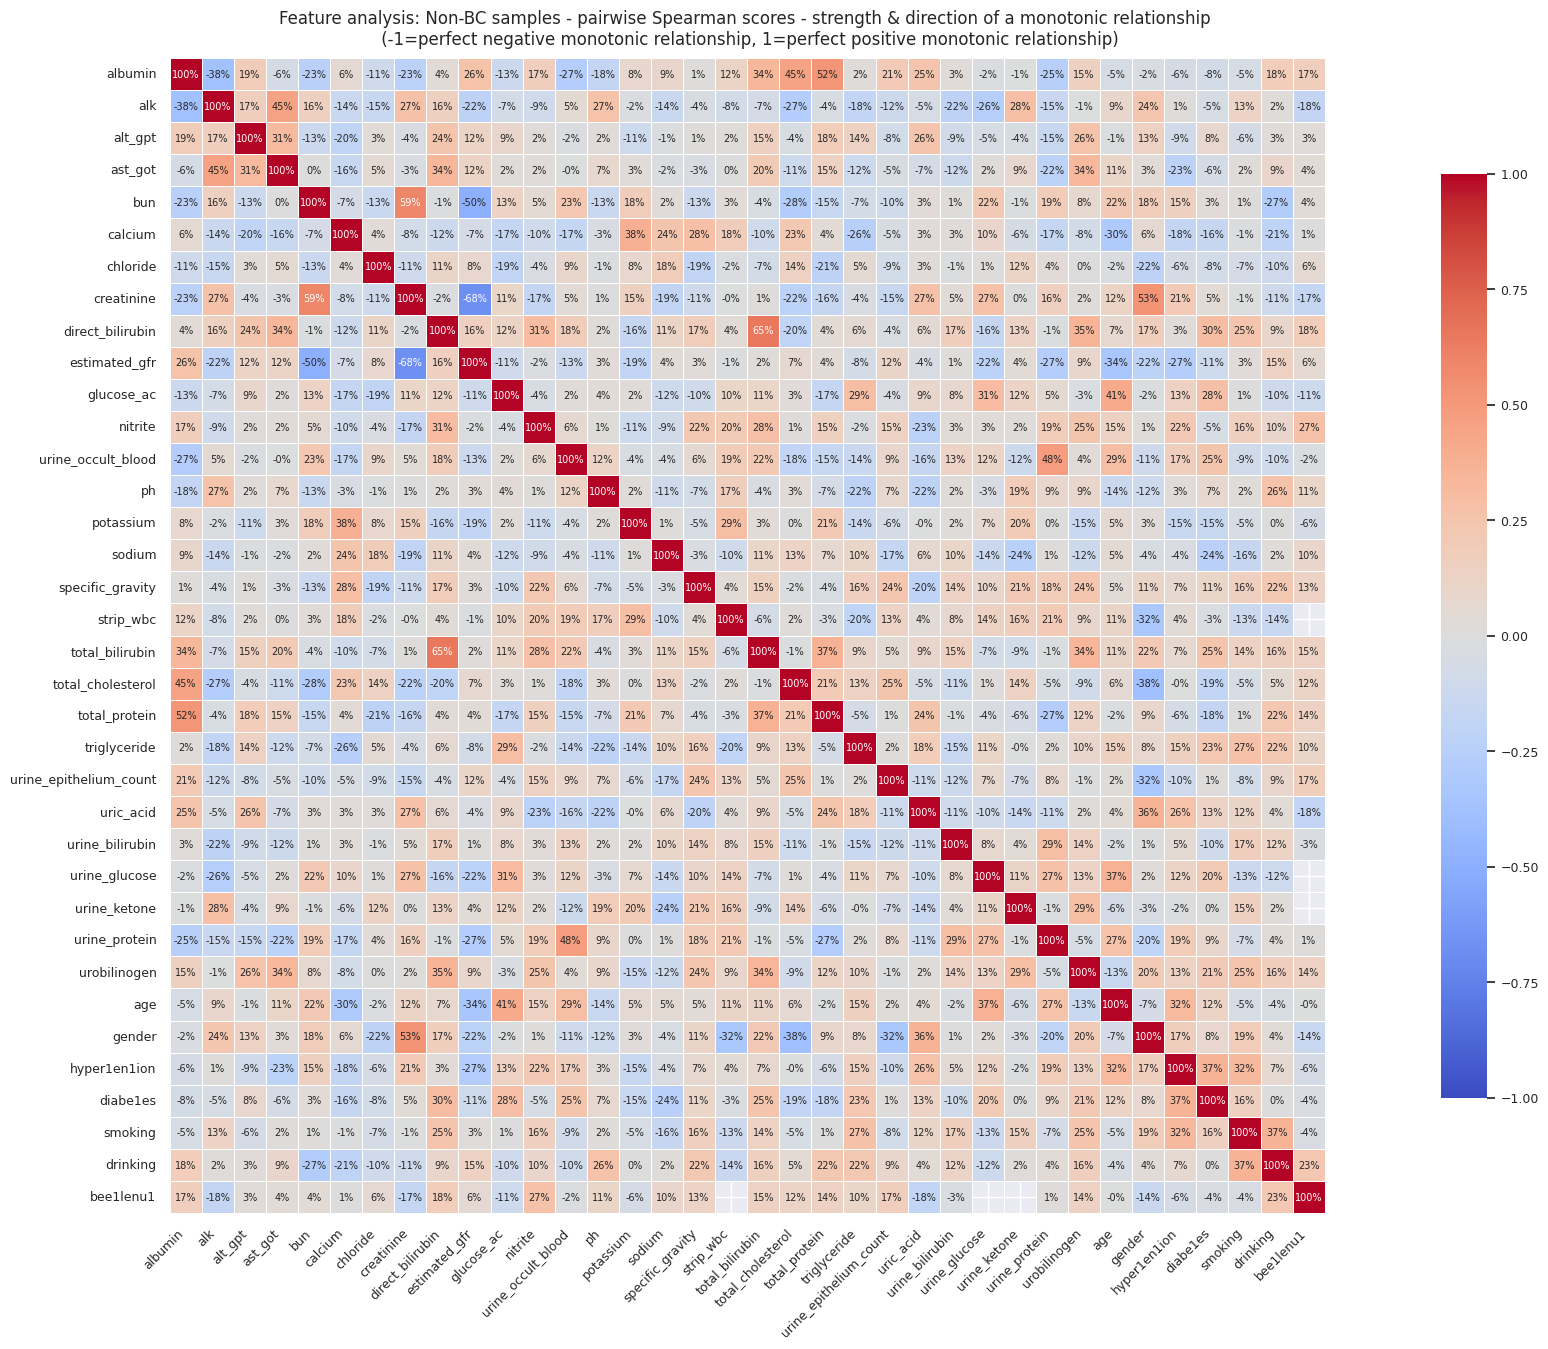

In [ ]:
# Get pairwise Spearman scores of strength of monotonic relationships for each pair of features
corr0=df.loc[df['disease1']==0].drop(columns=['disease1'],axis=1).corr('spearman')
# Did not consider 'ag_ratio' or 'urine_epitheilum_ul' as all missing for non-BC cases, also the target feature as it is nonsensical here
heatmap_plot(corr0,'Non-BC samples')

<font color='red'>Some scores are missing for 'bee1lenu1' which may be a result of this feature having low variance in its observed values and hence most of its ranks are the same and the correlation score is undefined</font>

##### 5.4.3 Cancer samples

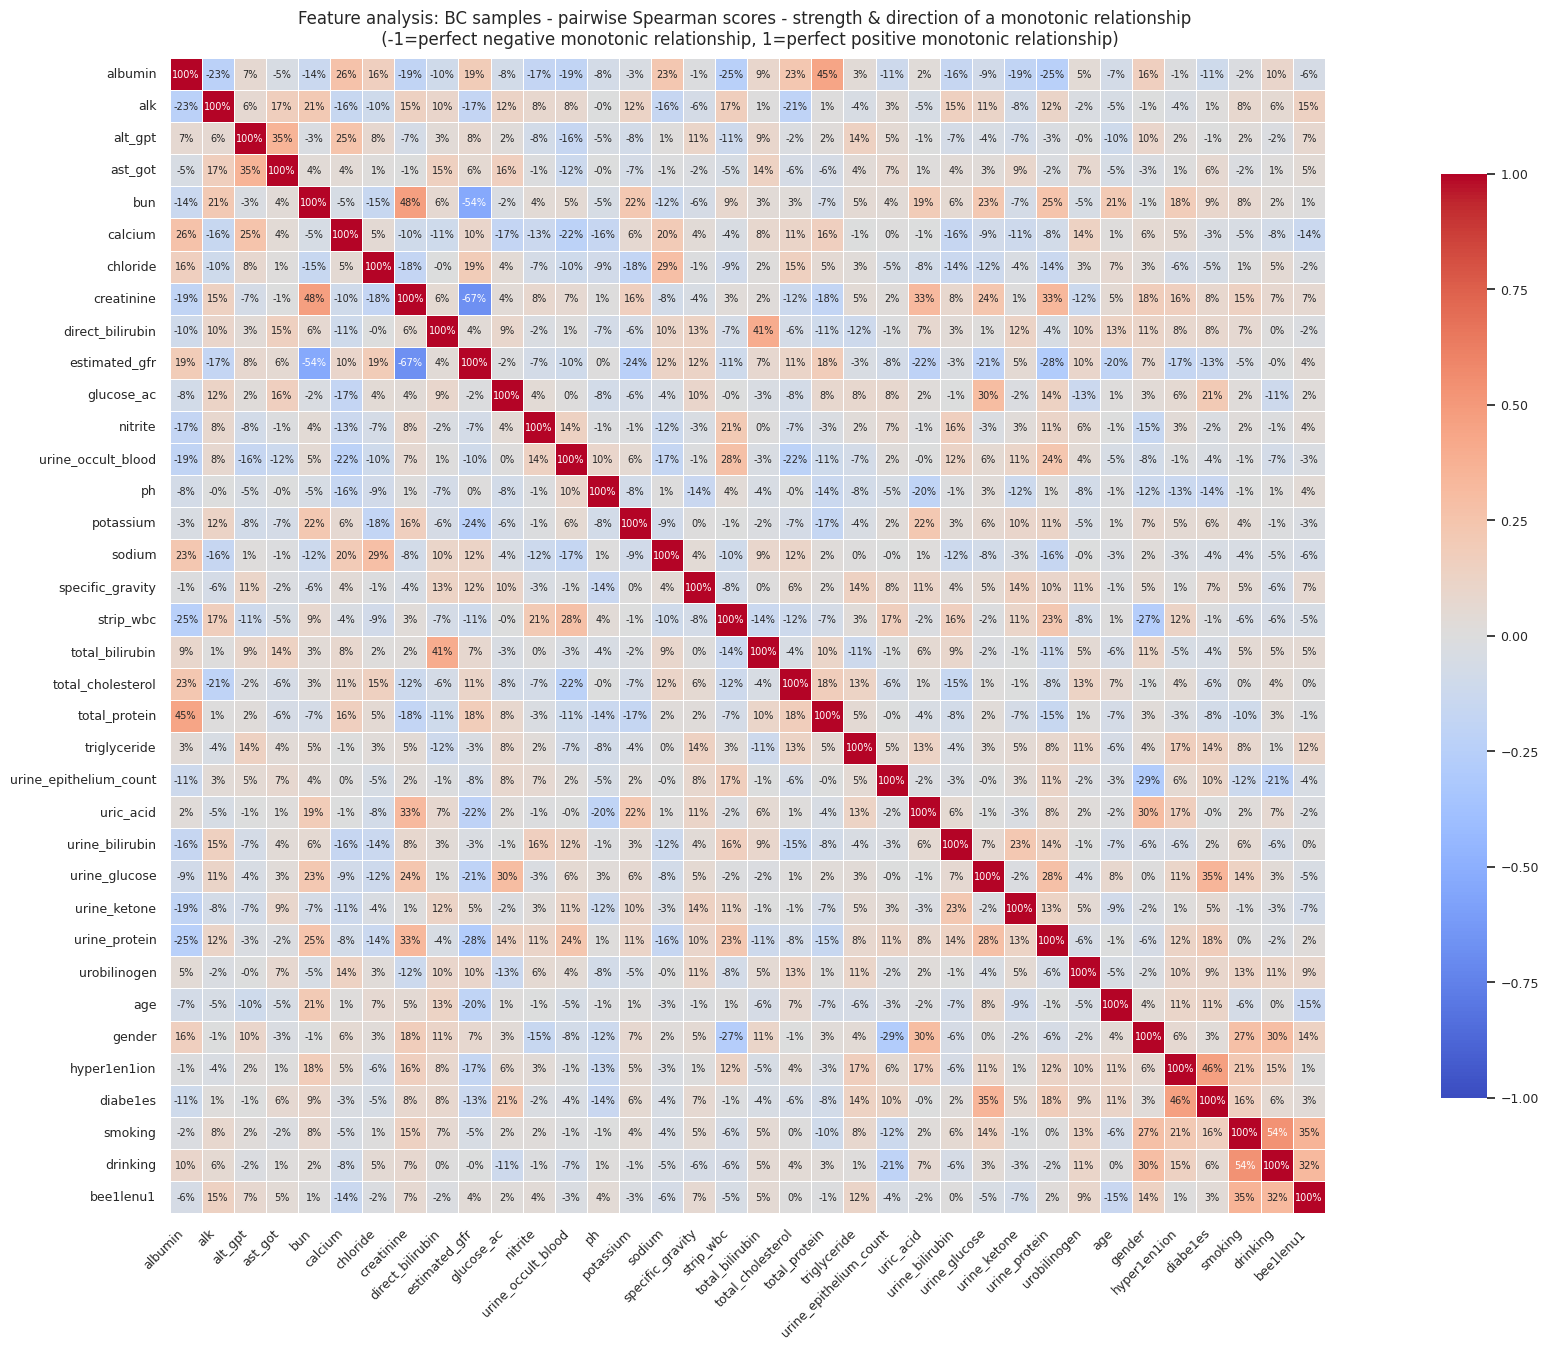

In [ ]:
# Get pairwise Spearman scores of strength of monotonic relationships for each pair of features
corr1=df.loc[df['disease1']==1].drop(columns=['disease1'],axis=1).corr('spearman')
# Did not consider 'ag_ratio' or 'urine_epitheilum_ul' as all missing for non-BC cases, also the target feature as it is nonsensical here
heatmap_plot(corr1,'BC samples')

#### 5.5. Feature-target linearity analysis

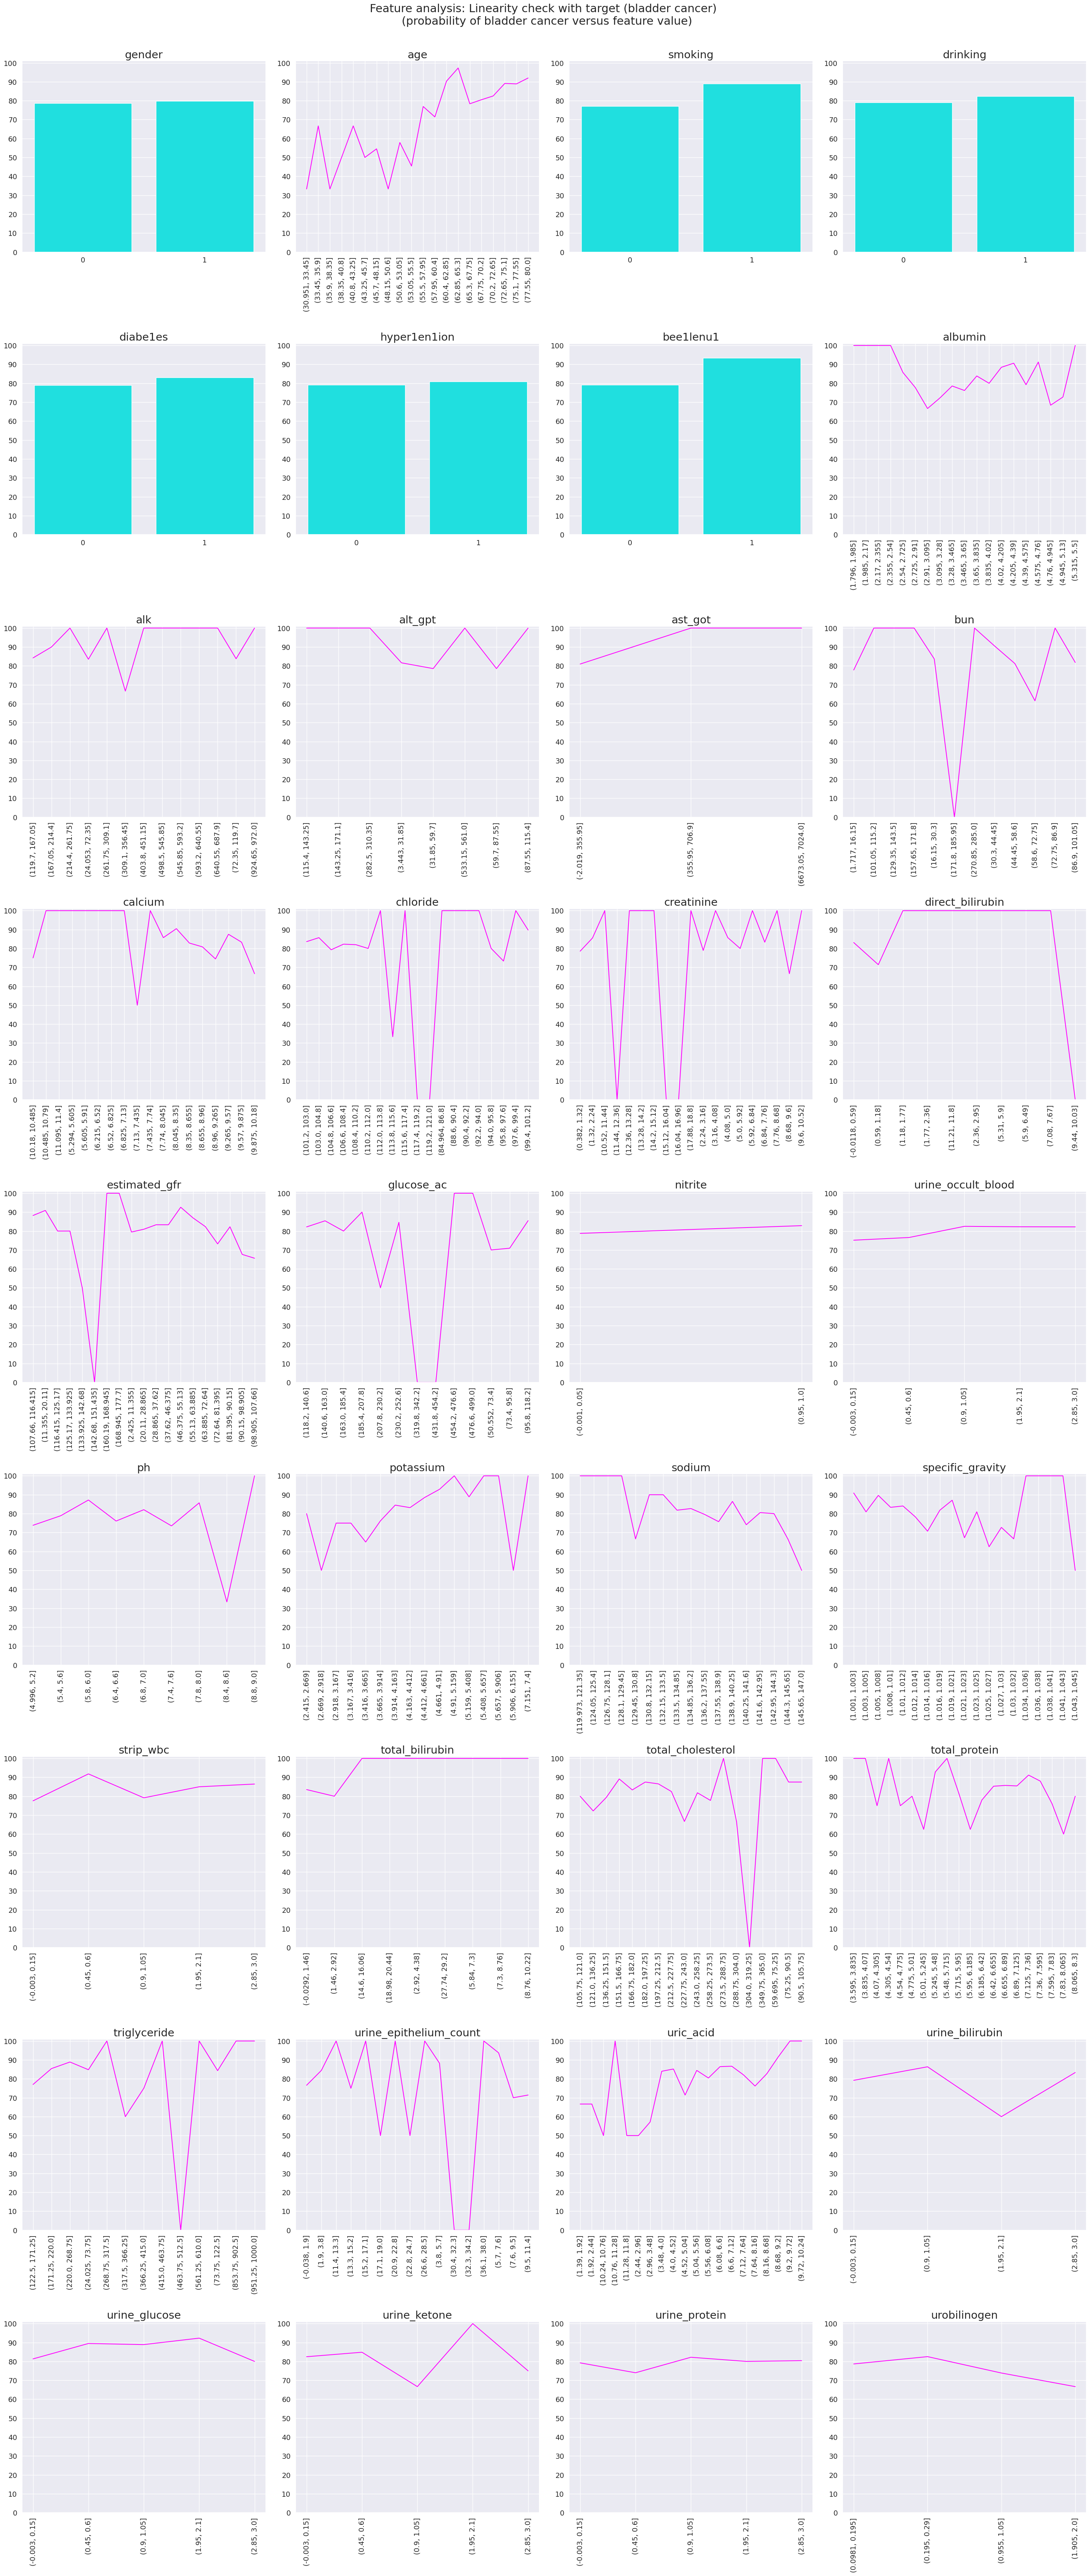

In [ ]:
fig, axes=plt.subplots(9,4,figsize=(30,70))

plt.suptitle('Feature analysis: Linearity check with target (bladder cancer) \n (probability of bladder cancer versus feature value)',fontsize=22, y=1.0)
sns.set(font_scale=1.75)

bc_linear_cat_plot(df,'gender','disease1',20,0,0)
bc_linear_plot(df,'age','disease1',20,0,1)
bc_linear_cat_plot(df,'smoking','disease1',20,0,2)
bc_linear_cat_plot(df,'drinking','disease1',20,0,3)

bc_linear_cat_plot(df,'diabe1es','disease1',20,1,0)
bc_linear_cat_plot(df,'hyper1en1ion','disease1',20,1,1)
bc_linear_cat_plot(df,'bee1lenu1','disease1',20,1,2)
bc_linear_plot(df,'albumin','disease1',20,1,3)

bc_linear_plot(df,'alk','disease1',20,2,0)
bc_linear_plot(df,'alt_gpt','disease1',20,2,1)
bc_linear_plot(df,'ast_got','disease1',20,2,2)
bc_linear_plot(df,'bun','disease1',20,2,3)

bc_linear_plot(df,'calcium','disease1',20,3,0)
bc_linear_plot(df,'chloride','disease1',20,3,1)
bc_linear_plot(df,'creatinine','disease1',20,3,2)
bc_linear_plot(df,'direct_bilirubin','disease1',20,3,3)

bc_linear_plot(df,'estimated_gfr','disease1',20,4,0)
bc_linear_plot(df,'glucose_ac','disease1',20,4,1)
bc_linear_plot(df,'nitrite','disease1',20,4,2)
bc_linear_plot(df,'urine_occult_blood','disease1',20,4,3)

bc_linear_plot(df,'ph','disease1',20,5,0)
bc_linear_plot(df,'potassium','disease1',20,5,1)
bc_linear_plot(df,'sodium','disease1',20,5,2)
bc_linear_plot(df,'specific_gravity','disease1',20,5,3)

bc_linear_plot(df,'strip_wbc','disease1',20,6,0)
bc_linear_plot(df,'total_bilirubin','disease1',20,6,1)
bc_linear_plot(df,'total_cholesterol','disease1',20,6,2)
bc_linear_plot(df,'total_protein','disease1',20,6,3)

bc_linear_plot(df,'triglyceride','disease1',20,7,0)
bc_linear_plot(df,'urine_epithelium_count','disease1',20,7,1)
bc_linear_plot(df,'uric_acid','disease1',20,7,2)
bc_linear_plot(df,'urine_bilirubin','disease1',20,7,3)

bc_linear_plot(df,'urine_glucose','disease1',20,8,0)
bc_linear_plot(df,'urine_ketone','disease1',20,8,1)
bc_linear_plot(df,'urine_protein','disease1',20,8,2)
bc_linear_plot(df,'urobilinogen','disease1',20,8,3)

plt.show()

<font color='red'>Most features show a non-linear relationship with the target feature. A few such as 'age' exhibit positive linearity with the target while some like 'nitrate' have a near constant probability of BC across their values so by themselves they may not be good predictors</font>

### 6. Impute missing values

Drop 'disease' as redundant

In [ ]:
df=df.drop(columns=['disease'], axis=1)
df_test=df_test.drop(columns=['disease'], axis=1)

#### 6.1. Test predictive power of dataset where missing values imputed by sklearn IteratorImputer - use RF for classifier


In [ ]:
X_train, y_train, X_test, y_test, X_train_imp, X_test_imp, num_cols=impute(df,splits=5,repeats=3) # Keep both of the splits and repeats small given the sample size

Training cv mean accuracy = 0.8244799225931302
Test accuracy: 0.7627906976744186


#### 6.2. Test predictive power of dataset with missing values imputed by sklearn KNNImputer - use RF classifier

In [ ]:
X_train, y_train, X_test, y_test, X_train_imp, X_test_imp, num_cols, best_k=knnimpute(df,splits=5,repeats=3) # Keep both of the splits and repeats small given the sample size


Best k = 7
Training cv mean accuracy = 0.8181422351233673
Test accuracy: 0.7674418604651163


<font color='red'>Will select KNN Imputer method as test accuracy is higher and closer to its validation mean accuracy and because of methodology review findings of Jerez et al (2010)</font>

#### 6.3 Impute missing values of training dataset using KNN Imputer with k=7



In [ ]:
imputer=KNNImputer(n_neighbors=7,weights='distance') # Using weights as per advice of Jerez et al (2010)
imputed_array=imputer.fit_transform(df)
df_imp=pd.DataFrame(imputed_array,columns=df.columns)

In [ ]:
# Apply imputation transformation from training to test dataset
test_imputed_array=imputer.transform(df_test)
df_test_imp=pd.DataFrame(test_imputed_array,columns=df_test.columns)

In [ ]:
# Apply a fix to gender which has 3 missings imputed as numbers between 0 and 1 - only required for training as test set had no missings
df_imp.loc[(df_imp['gender']>0) & (df_imp['gender']<1)]=1

Before imputation:

In [ ]:
df.head(5)

albumin   alk  alt_gpt  ast_got   bun  calcium  chloride  creatinine  \
643      4.5  79.0     22.0     20.0  14.0      NaN     110.0         0.7   
344      NaN   NaN     61.0     48.0  22.0      NaN       NaN         0.9   
178      4.6  54.0     16.0     23.0  16.0      NaN     107.0         0.9   
457      NaN   NaN     24.0     42.0  16.0      NaN     108.0         1.5   
702      2.9  85.0     12.0     19.0  14.0      8.5     108.0         1.0   

     direct_bilirubin  estimated_gfr  ...  urine_protein  urobilinogen   age  \
643               0.1           83.5  ...            NaN           NaN  73.0   
344               0.2           98.4  ...            0.0           0.2  48.0   
178               0.1           98.0  ...            0.0           0.2  65.0   
457               NaN           47.5  ...            0.0           0.1  67.0   
702               0.2           46.3  ...            3.0           0.2  72.0   

     gender  hyper1en1ion  diabe1es  smoking  drinking  bee1lenu1  disease1  
643     0.0           0.0       0.0      0.0       1.0        0.0         0  
344     1.0           0.0       0.0      0.0       0.0        0.0         0  
178     1.0           0.0       0.0      0.0       1.0        0.0         1  
457     1.0           0.0       0.0      1.0       0.0        0.0         1  
702     1.0           0.0       0.0      0.0       0.0        0.0         1  

[5 rows x 37 columns]

In [ ]:
df_test.head()

albumin   alk  alt_gpt  ast_got   bun  calcium  chloride  creatinine  \
559     3.50  88.0     11.0     17.0  12.0      NaN     105.0        1.10   
33      4.20   NaN    190.0    164.0  13.0      NaN       NaN        1.10   
275     4.90  80.0     44.0     17.0  15.0     9.28     109.0        1.30   
198      NaN   NaN     11.0     22.0   NaN      NaN       NaN        0.80   
192     4.19  81.0     44.0     26.0  19.0     8.70     106.2        0.38   

     direct_bilirubin  estimated_gfr  ...  urine_protein  urobilinogen   age  \
559              0.10           94.5  ...            1.0           1.0  63.0   
33                NaN           72.4  ...            0.0           1.0  72.0   
275              0.20           50.2  ...            2.0           1.0  73.0   
198               NaN           71.7  ...            0.0           0.1  73.0   
192              0.13          181.5  ...            3.0           0.2  50.0   

     gender  hyper1en1ion  diabe1es  smoking  drinking  bee1lenu1  disease1  
559     1.0           0.0       0.0      0.0       0.0        0.0         1  
33      0.0           0.0       0.0      0.0       0.0        0.0         1  
275     1.0           1.0       1.0      1.0       1.0        0.0         1  
198     0.0           0.0       0.0      0.0       0.0        0.0         0  
192     0.0           0.0       0.0      0.0       0.0        0.0         1  

[5 rows x 37 columns]

After imputation:
- Note that the indexes are reset becuase of the conversion of an array to a dataframe

In [ ]:
df_imp.head()

albumin        alk  alt_gpt  ast_got   bun   calcium    chloride  \
0  4.500000  79.000000     22.0     20.0  14.0  9.231955  110.000000   
1  4.267736  77.719939     61.0     48.0  22.0  9.201584  104.946461   
2  4.600000  54.000000     16.0     23.0  16.0  9.348711  107.000000   
3  4.268444  71.147044     24.0     42.0  16.0  9.111505  108.000000   
4  2.900000  85.000000     12.0     19.0  14.0  8.500000  108.000000   

   creatinine  direct_bilirubin  estimated_gfr  ...  urine_protein  \
0         0.7          0.100000           83.5  ...       0.936506   
1         0.9          0.200000           98.4  ...       0.000000   
2         0.9          0.100000           98.0  ...       0.000000   
3         1.5          0.114401           47.5  ...       0.000000   
4         1.0          0.200000           46.3  ...       3.000000   

   urobilinogen   age  gender  hyper1en1ion  diabe1es  smoking  drinking  \
0      0.627034  73.0     0.0           0.0       0.0      0.0       1.0   
1      0.200000  48.0     1.0           0.0       0.0      0.0       0.0   
2      0.200000  65.0     1.0           0.0       0.0      0.0       1.0   
3      0.100000  67.0     1.0           0.0       0.0      1.0       0.0   
4      0.200000  72.0     1.0           0.0       0.0      0.0       0.0   

   bee1lenu1  disease1  
0        0.0       0.0  
1        0.0       0.0  
2        0.0       1.0  
3        0.0       1.0  
4        0.0       1.0  

[5 rows x 37 columns]

In [ ]:
df_test_imp.head()

albumin         alk  alt_gpt  ast_got        bun   calcium    chloride  \
0  3.500000   88.000000     11.0     17.0  12.000000  9.475382  105.000000   
1  4.200000  144.939814    190.0    164.0  13.000000  9.195204  108.179596   
2  4.900000   80.000000     44.0     17.0  15.000000  9.280000  109.000000   
3  4.506076   62.455137     11.0     22.0  16.085489  9.380915  105.982724   
4  4.190000   81.000000     44.0     26.0  19.000000  8.700000  106.200000   

   creatinine  direct_bilirubin  estimated_gfr  ...  urine_protein  \
0        1.10          0.100000           94.5  ...            1.0   
1        1.10          0.370424           72.4  ...            0.0   
2        1.30          0.200000           50.2  ...            2.0   
3        0.80          0.111236           71.7  ...            0.0   
4        0.38          0.130000          181.5  ...            3.0   

   urobilinogen   age  gender  hyper1en1ion  diabe1es  smoking  drinking  \
0           1.0  63.0     1.0           0.0       0.0      0.0       0.0   
1           1.0  72.0     0.0           0.0       0.0      0.0       0.0   
2           1.0  73.0     1.0           1.0       1.0      1.0       1.0   
3           0.1  73.0     0.0           0.0       0.0      0.0       0.0   
4           0.2  50.0     0.0           0.0       0.0      0.0       0.0   

   bee1lenu1  disease1  
0        0.0       1.0  
1        0.0       1.0  
2        0.0       1.0  
3        0.0       0.0  
4        0.0       1.0  

[5 rows x 37 columns]

In [ ]:
# Save to Google Drive
df_imp.to_pickle('/content/drive/My Drive/DSM500/Dataframes/df_imp.pkl')
df_test_imp.to_pickle('/content/drive/My Drive/DSM500/Dataframes/df_test_imp.pkl')

### 7. Standardize features

<font color='red'>Standardize each feature so that they have the same scale and outliers do not affect the model builds</font>

<font color='red'>**Note: The standardized datasets created below are not used. the standardization step was moved to the data augmentation stage (see codes 'II'). This is because the cleaned data needed to be transformed ahead of data augmentation so that negative values were not generated. Standardization is then applied to augmented datasets**</font>

In [ ]:
# Get all numeric features for standardization
features=df_imp.drop('disease1', axis=1)
# Standardize numeric features
scaler=MinMaxScaler()
features_std=scaler.fit_transform(features)
# Combine the standardized features with the target feature
features_std=pd.DataFrame(features_std, columns=features.columns)
features_std['disease1']=df_imp['disease1']
df_imp_std=features_std

In [ ]:
df_imp_std.head()

albumin       alk   alt_gpt   ast_got       bun   calcium  chloride  \
0  0.777778  0.080330  0.037500  0.002705  0.045775  0.791534  0.908333   
1  0.726164  0.079011  0.107143  0.006692  0.073944  0.788614  0.866221   
2  0.800000  0.054583  0.026786  0.003133  0.052817  0.802761  0.883333   
3  0.726321  0.072242  0.041071  0.005838  0.052817  0.779952  0.891667   
4  0.422222  0.086509  0.019643  0.002563  0.045775  0.721154  0.891667   

   creatinine  direct_bilirubin  estimated_gfr  ...  urine_protein  \
0    0.016304          0.008475       0.466893  ...       0.312169   
1    0.027174          0.016949       0.551217  ...       0.000000   
2    0.027174          0.008475       0.548953  ...       0.000000   
3    0.059783          0.009695       0.263158  ...       0.000000   
4    0.032609          0.016949       0.256367  ...       1.000000   

   urobilinogen       age  gender  hyper1en1ion  diabe1es  smoking  drinking  \
0      0.277386  0.911392     0.0           0.0       0.0      0.0       1.0   
1      0.052632  0.594937     1.0           0.0       0.0      0.0       0.0   
2      0.052632  0.810127     1.0           0.0       0.0      0.0       1.0   
3      0.000000  0.835443     1.0           0.0       0.0      1.0       0.0   
4      0.052632  0.898734     1.0           0.0       0.0      0.0       0.0   

   bee1lenu1  disease1  
0        0.0       0.0  
1        0.0       0.0  
2        0.0       1.0  
3        0.0       1.0  
4        0.0       1.0  

[5 rows x 37 columns]

Apply standardization transformation from training to test dataset

In [ ]:
test_features=df_test_imp.drop('disease1', axis=1)
# Standardize numeric features
test_features_std=scaler.transform(test_features)
# Combine the scaled features with the target feature
test_features_std=pd.DataFrame(test_features_std, columns=test_features.columns)
test_features_std['disease1']=df_test_imp['disease1']
df_test_imp_std=test_features_std

In [ ]:
df_test_imp_std.head()

albumin       alk   alt_gpt   ast_got       bun   calcium  chloride  \
0  0.555556  0.089598  0.017857  0.002278  0.038732  0.814941  0.866667   
1  0.711111  0.148239  0.337500  0.023209  0.042254  0.788000  0.893163   
2  0.866667  0.081359  0.076786  0.002278  0.049296  0.796154  0.900000   
3  0.779128  0.063291  0.017857  0.002990  0.053118  0.805857  0.874856   
4  0.708889  0.082389  0.076786  0.003560  0.063380  0.740385  0.876667   

   creatinine  direct_bilirubin  estimated_gfr  ...  urine_protein  \
0    0.038043          0.008475       0.529145  ...       0.333333   
1    0.038043          0.031392       0.404075  ...       0.000000   
2    0.048913          0.016949       0.278438  ...       0.666667   
3    0.021739          0.009427       0.400113  ...       0.000000   
4   -0.001087          0.011017       1.021505  ...       1.000000   

   urobilinogen       age  gender  hyper1en1ion  diabe1es  smoking  drinking  \
0      0.473684  0.784810     1.0           0.0       0.0      0.0       0.0   
1      0.473684  0.898734     0.0           0.0       0.0      0.0       0.0   
2      0.473684  0.911392     1.0           1.0       1.0      1.0       1.0   
3      0.000000  0.911392     0.0           0.0       0.0      0.0       0.0   
4      0.052632  0.620253     0.0           0.0       0.0      0.0       0.0   

   bee1lenu1  disease1  
0        0.0       1.0  
1        0.0       1.0  
2        0.0       1.0  
3        0.0       0.0  
4        0.0       1.0  

[5 rows x 37 columns]

In [ ]:
# Save to Google Drive
df_imp_std.to_pickle('/content/drive/My Drive/DSM500/Dataframes/df_imp_std.pkl')
df_test_imp_std.to_pickle('/content/drive/My Drive/DSM500/Dataframes/df_test_imp_std.pkl')